<a href="https://colab.research.google.com/github/austinbennysmith/OSOM-ERDDAP/blob/master/Suomi_NPP_VIIRS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook works with datasets on the [RIDDC ERDDAP server](https://pricaimcit.services.brown.edu/erddap/index.html) that was produced by the Visible and Infrared Imager/Radiometer Suite (VIIRS) as part of the Suomi National Polar-orbiting Partnership (NPP). These datasets have measurements of chlorophyll a, the diffuse attenuation coefficient at 490 nm (K490), photosynthetically available radiation, particulate inorganic carbon, particulate organic carbon, and reflectance at 671 nm. For each of these variables, there is a dataset of monthly, 8 day, and 1 day composites.

Here is a list of the dataset IDs: erdVH2018chla8day, erdVH2018chla1day, erdVH2018chlamday, erdVH2018k4908day, erdVH2018k4901day, erdVH2018k490mday, erdVH2018par8day, erdVH2018par1day, erdVH2018parmday, erdVH2018pic8day, erdVH2018pic1day, erdVH2018picmday, erdVH2018poc8day, erdVH2018poc1day, erdVH2018pocmday, erdVH2018r6718day, erdVH2018r6711day, erdVH2018r671mday

First, Colab requires some installations and imports:

In [ ]:
!pip install netCDF4
import requests
from netCDF4 import Dataset as NetCDFFile
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
#To use cartopy in a Colab notebook, I need a particular sequence of installs (as shown at this notebook: https://colab.research.google.com/github/adamlamee/CODINGinK12/blob/master/notebooks/quakes.ipynb#scrollTo=3LkZkXvnMAr4)
!apt-get -qq install python-cartopy python3-cartopy;
!pip uninstall -y shapely;
!pip install shapely --no-binary shapely;
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from matplotlib.axes import Axes
from cartopy.mpl.geoaxes import GeoAxes
GeoAxes._pcolormesh_patched = Axes.pcolormesh
import calendar
import datetime

Next, the code will ask which dataset to look at, create a list of dates, and define some variables based on the dataset ID. A list of acceptable dataset IDs is commented in the code, as well as in the introductory text above. Defining these variables will allow later code cells to access the correct data and graph/save it with appropriate labels.

In [5]:
#Some of the code dealing with datetime here is based on code at this link: https://stackoverflow.com/questions/1060279/iterating-through-a-range-of-dates-in-python
#This link also helped with datetime stuff: https://stackoverflow.com/questions/5734438/how-to-create-a-month-iterator
#To save images, I mount google drive:
#from google.colab import drive
#drive.mount('/content/gdrive')
import datetime
from datetime import date, timedelta
from datetime import datetime as dt
dates2 = [] #Creating a dates list that I'll add to later
#Acceptable dataset IDs: ['erdVH2018chla8day', 'erdVH2018chla1day', 'erdVH2018chlamday', 'erdVH2018k4908day', 'erdVH2018k4901day', 'erdVH2018k490mday', 'erdVH2018par8day', 'erdVH2018par1day', 'erdVH2018parmday', 'erdVH2018pic8day', 'erdVH2018pic1day', 'erdVH2018picmday', 'erdVH2018poc8day', 'erdVH2018poc1day', 'erdVH2018pocmday', 'erdVH2018r6718day', 'erdVH2018r6711day', 'erdVH2018r671mday']
dataset_id = input("What's the dataset ID?") #must put in one of the IDs linked above
#Define a directory for saving images:
#images_dir = '/content/gdrive/Shared drives/BFK_BOG/SURF_UG/Benny/Images/Phytoplankton_averages'
tres = dataset_id[-4:] #Figures out whether we're looking at Monthly, 8 Day, or 1 Day Composites.
#NOTE: later cells are pretty slow and will not be very fun to use for the 8 Day or 1 Day composites.
#The following if statements & while loops create a list of dates that I'll iterate through later. The dates2 list is different depending on the time resolution.
if tres=='8day':
  tt = '8 Day '
  start_date = date(2012, 1, 5)
  end_date = date(2020, 5, 12) #The datasets are updated continuously, so if you want the actual end date you'll need to check the server
  delta = timedelta(days = 8)
  while start_date<=end_date:
    dates2.append(str(start_date))
    start_date += delta
elif tres=='1day':
  tt = '1 Day '
  start_date = date(2012, 1, 2)
  end_date = date(2020, 6, 8)
  delta = timedelta(days = 1)
  while start_date<=end_date:
    dates2.append(str(start_date))
    start_date += delta
elif tres=='mday':
  tt = 'Monthly '
  start_date = date(2012, 1, 15)
  end_date = date(2020, 4, 15)
  def months_looping(start_month, start_year, end_month, end_year):
    start_date = datetime.date(start_year, start_month, 1)
    end_date = datetime.date(end_year, end_month, 1)
    date = start_date
    while date <= end_date:
        yield (date.month, date.year)
        new_new = str(datetime.date(date.year, date.month, 15))
        dates2.append(new_new)
        days_in_month = calendar.monthrange(date.year, date.month)[1]
        date += datetime.timedelta(days_in_month)
  def months(start_month, start_year, end_month, end_year):
    return tuple(d for d in months_looping(start_month, start_year, end_month, end_year))
  months(1, 2012, 4, 2020)
#These conditional statements set up variables used in the plots later on & in generating a url from which I'll get the data
if 'chla' in dataset_id:
  myvar = 'chla'
  unit = 'mg m^-3'
  title = 'Chlorophyll a '
elif 'k490' in dataset_id:
  myvar = 'k490'
  unit = 'm^-1'
  title = 'K490 '
elif 'par' in dataset_id:
  myvar = 'par'
  unit = 'einstein m^-2 day ^-1'
  title = 'Photosynthetically Available Radiation '
elif 'pic' in dataset_id:
  myvar = 'pic'
  unit = 'mol m^-3'
  title = 'Particulate Inorganic Carbon '
elif 'poc' in dataset_id:
  myvar = 'poc'
  unit = 'mg m^-3'
  title = 'Particulate Organic Carbon '
elif 'r671' in dataset_id:
  myvar = 'r671'
  unit = 'sr^-1'
  title = 'Reflectance at 671 nm '

What's the dataset ID?erdVH2018chlamday


Next, I iterate through the list of dates I've created, make a map of the variable I'm focused on at each time stamp, take the average over the entire region for that time stamp, and graph the spatial averages over time.

**NOTE: This is an extremely slow way to graph the averages. For a faster program, see the notebok titled "MODIS & VIIRS Faster Comparisons. However, I am still including this notebook because it can look at any of the variables listed in the ERDDAP server for Suomi-NPP/VIIRS. The faster notebook currently only deals with chlorophyll a and K490.**

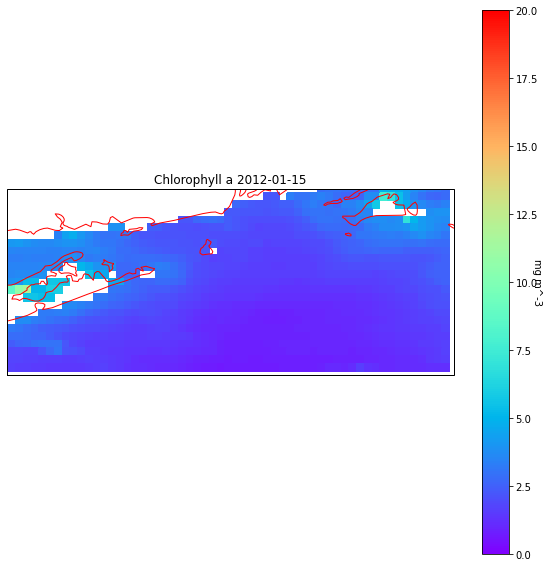

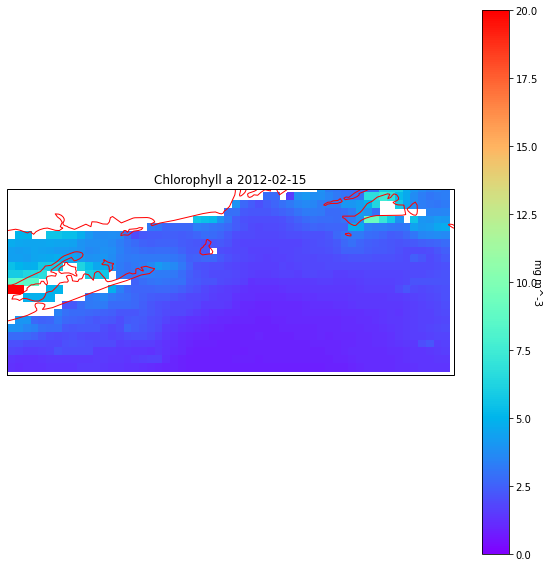

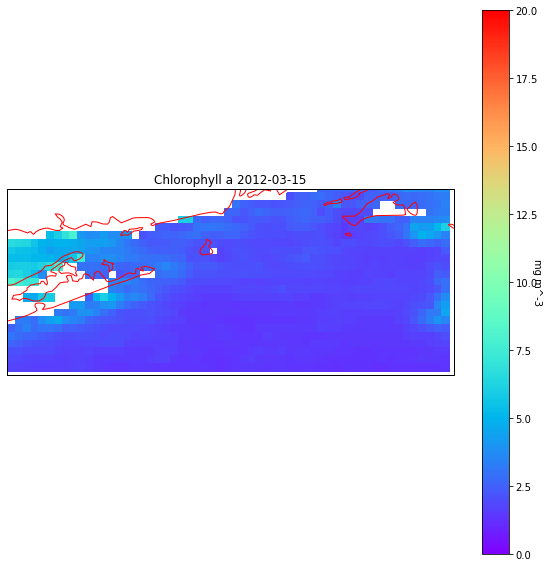

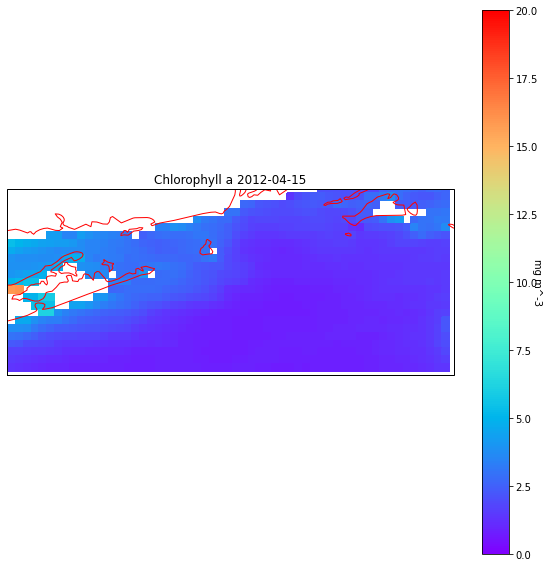

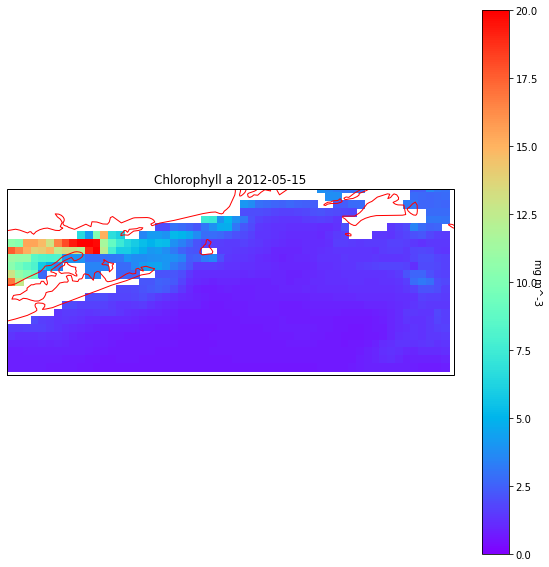

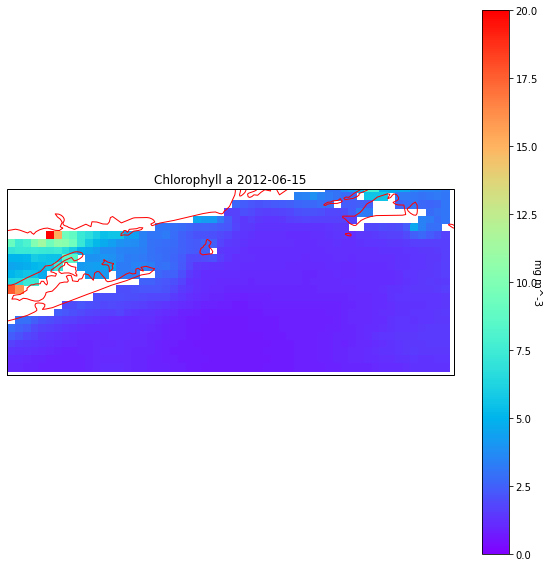

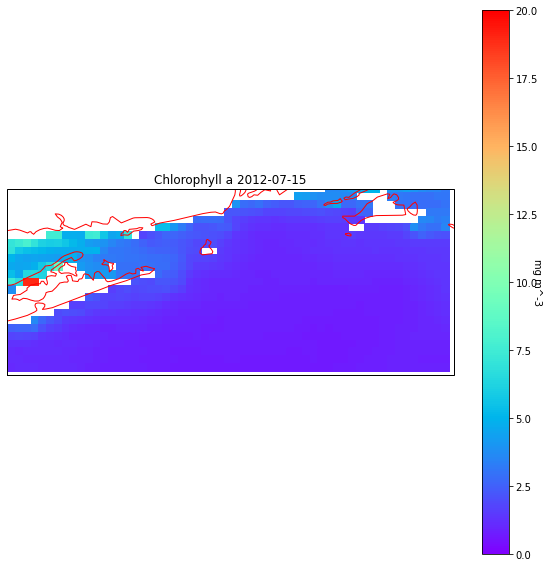

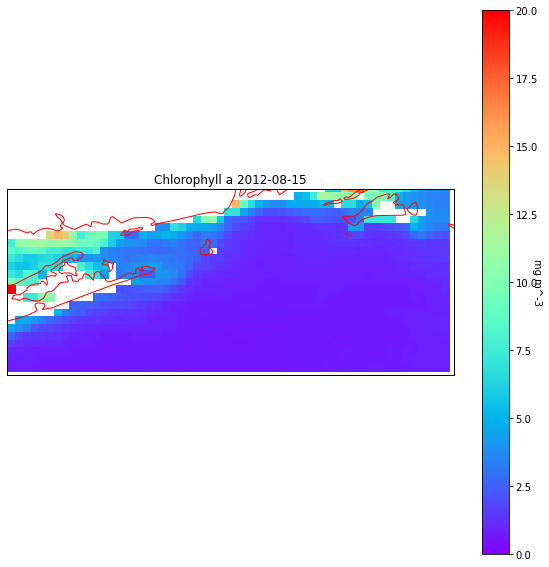

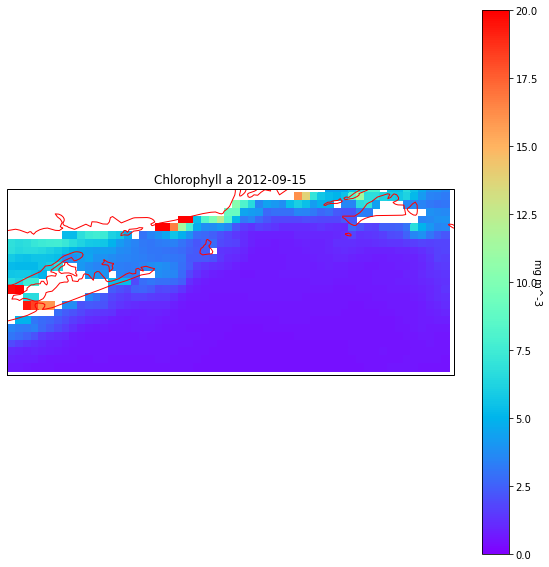

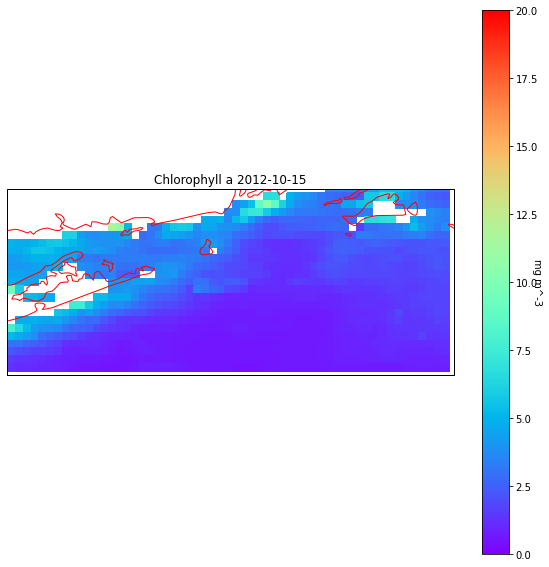

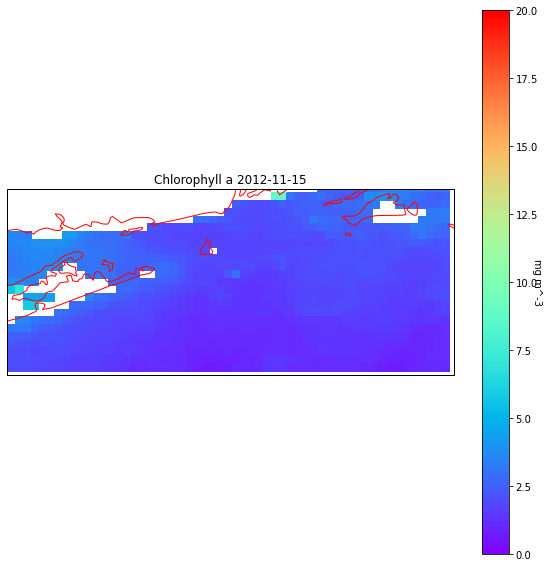

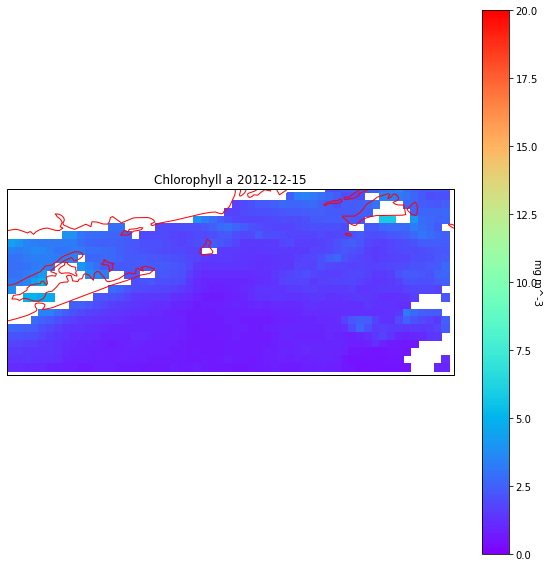

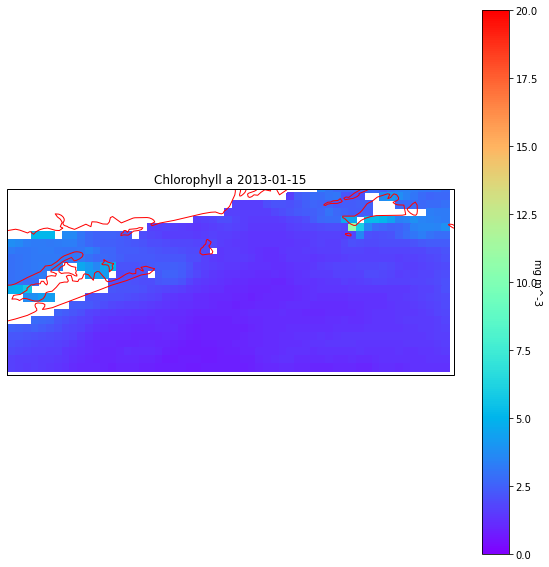

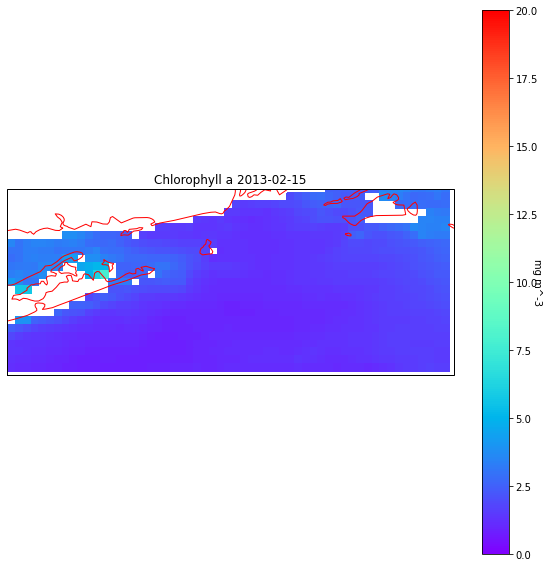

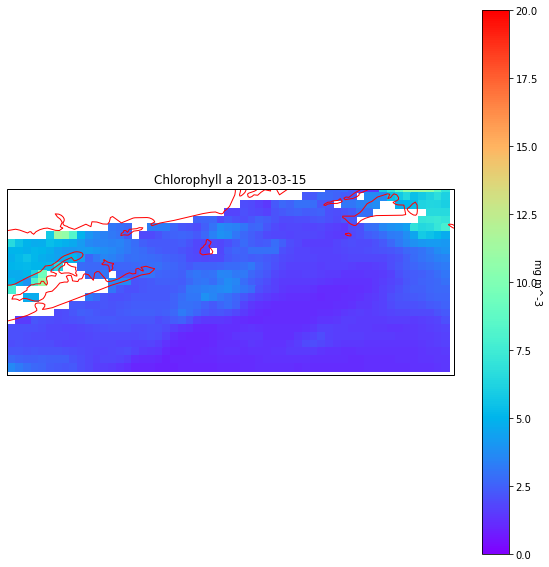

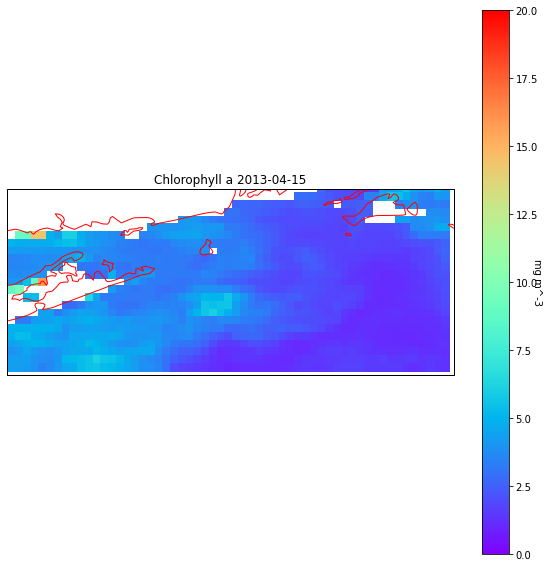

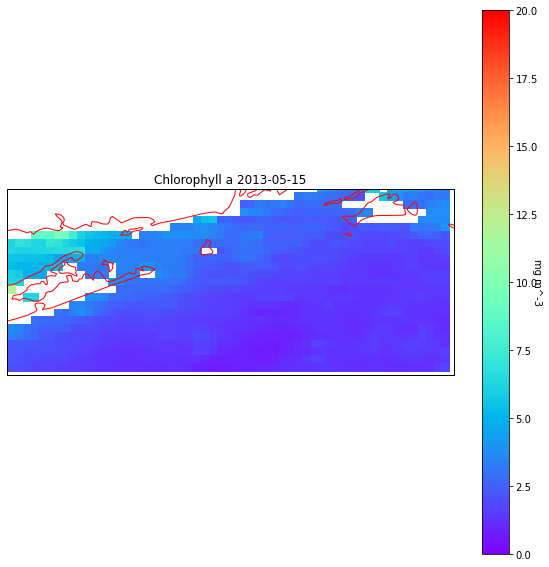

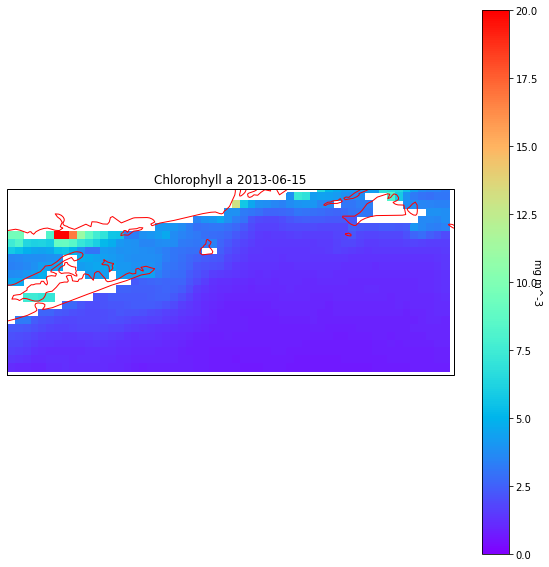

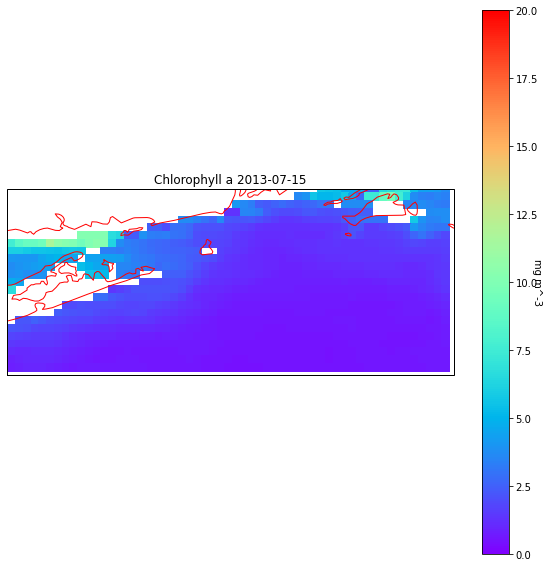

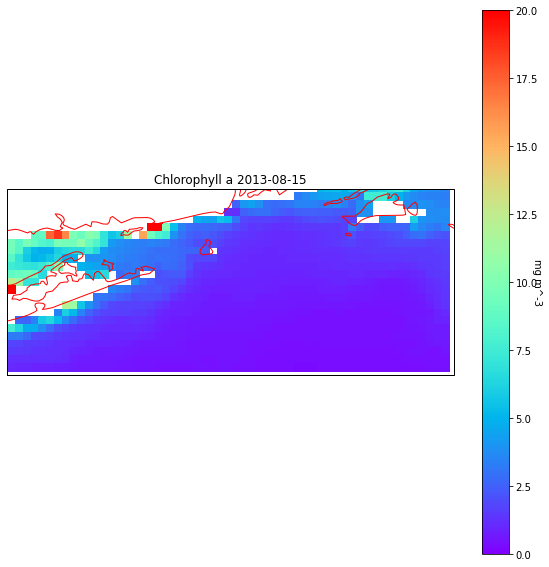

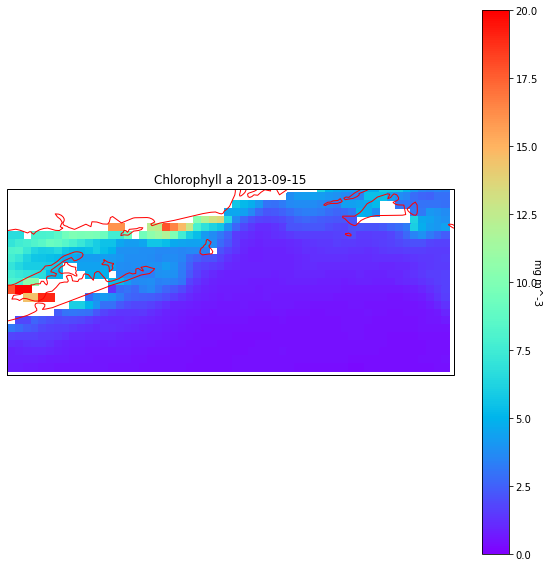

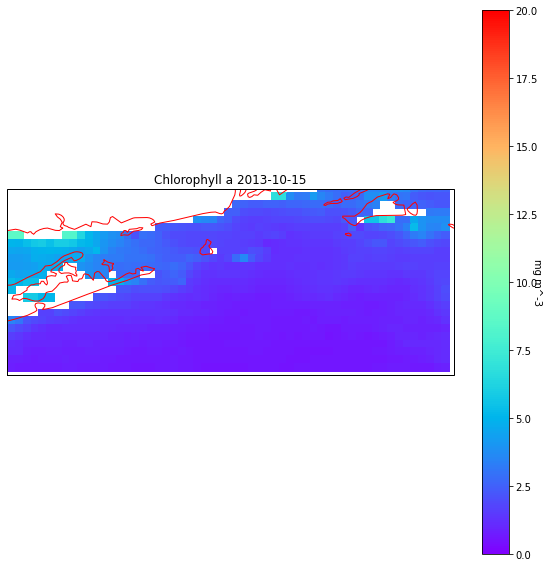

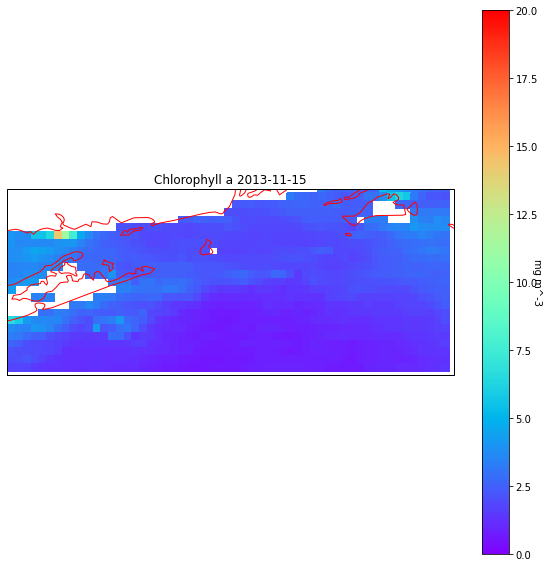

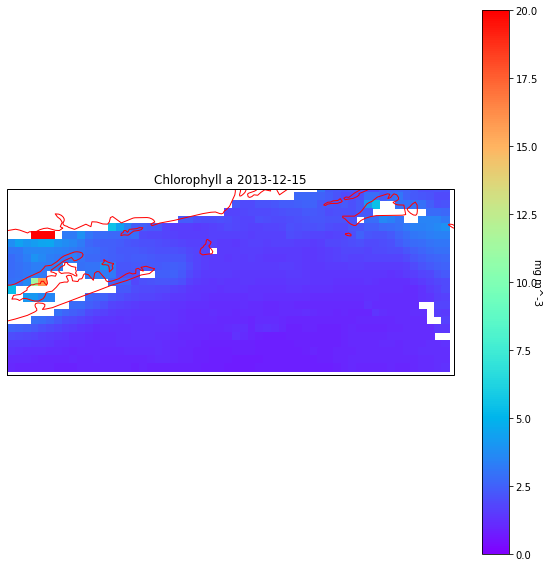

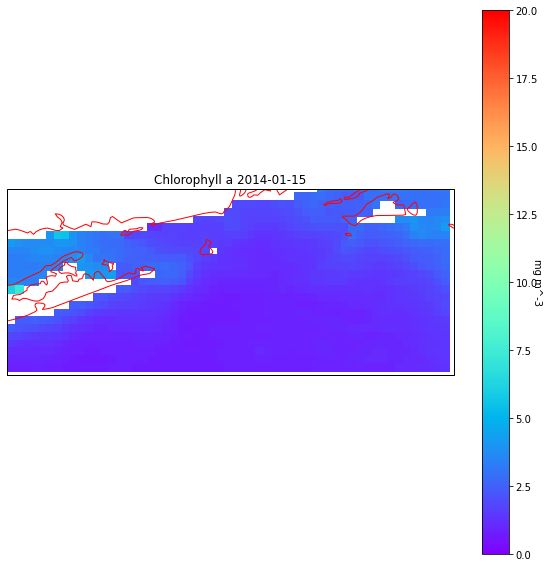

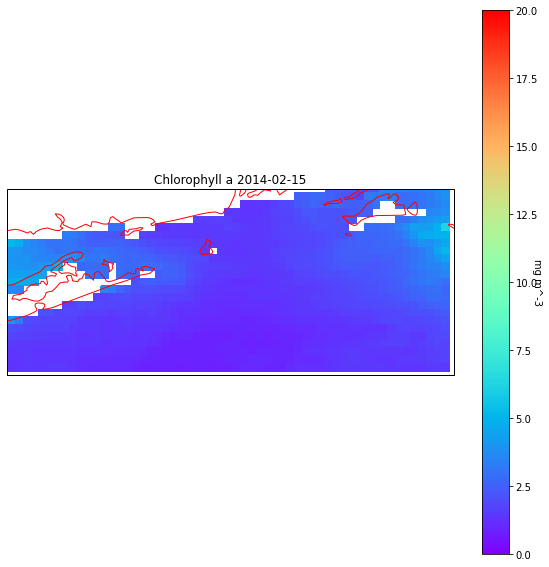

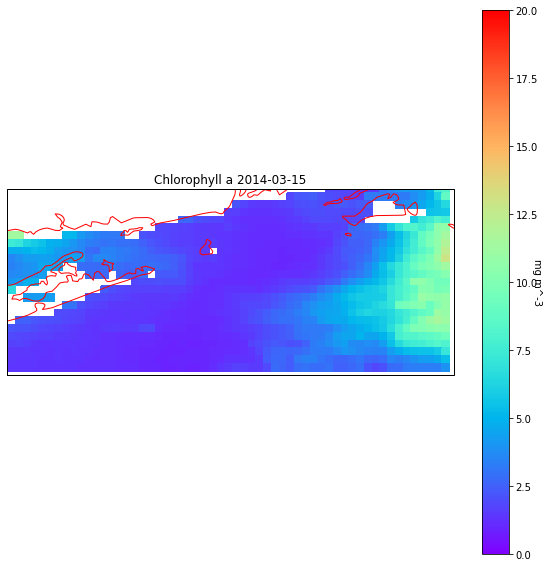

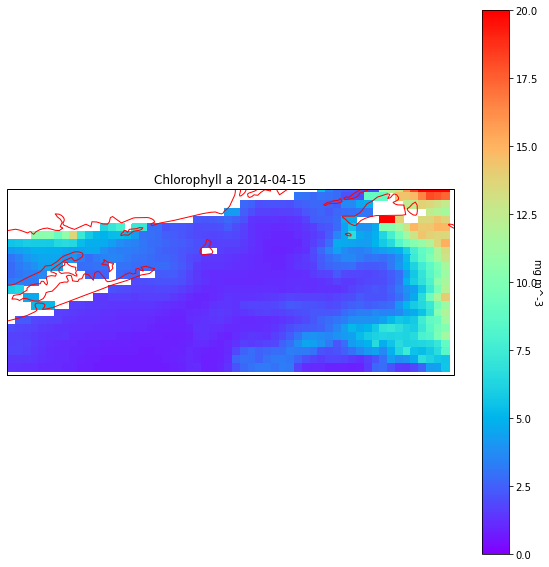

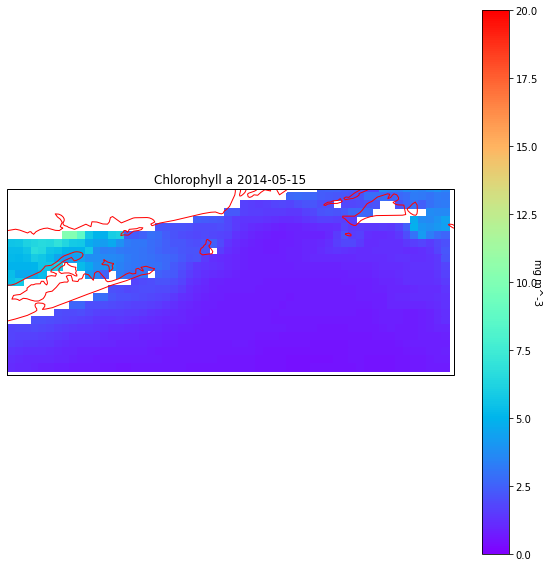

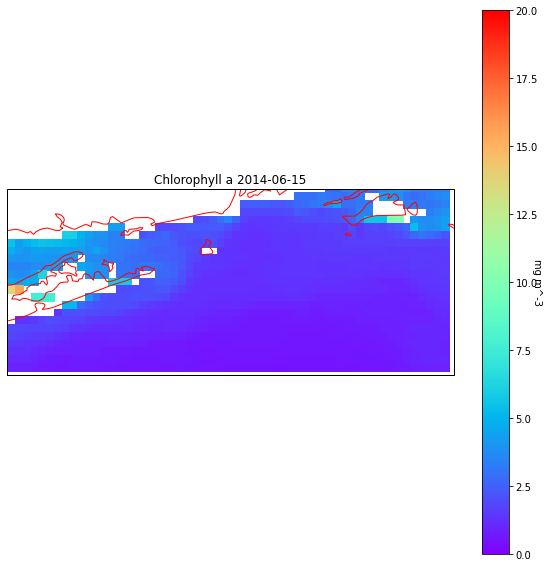

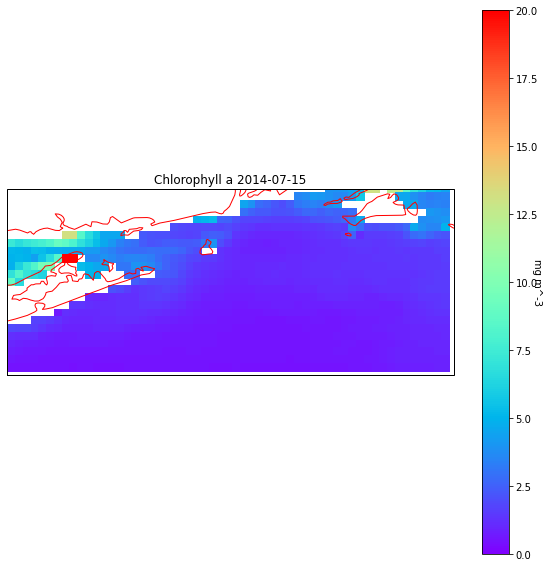

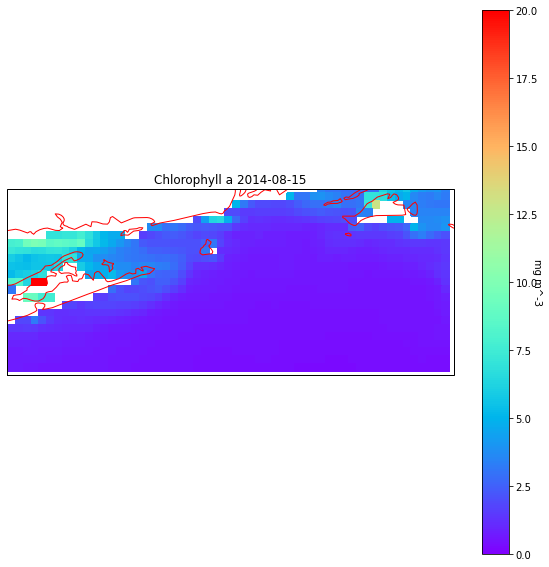

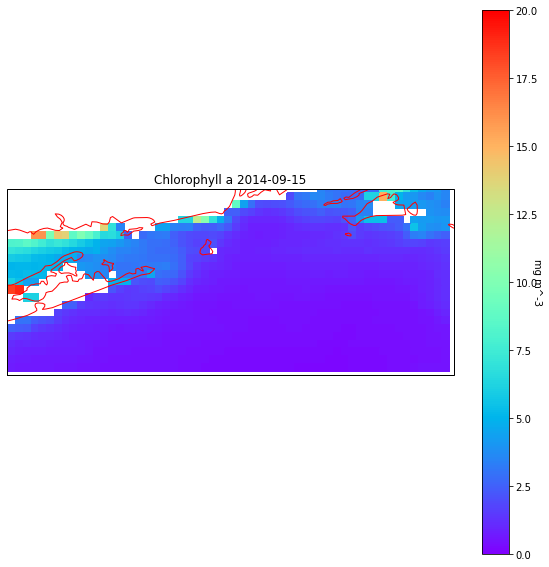

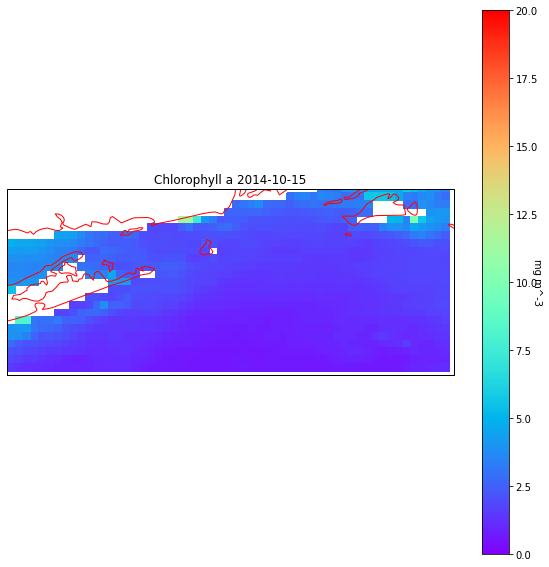

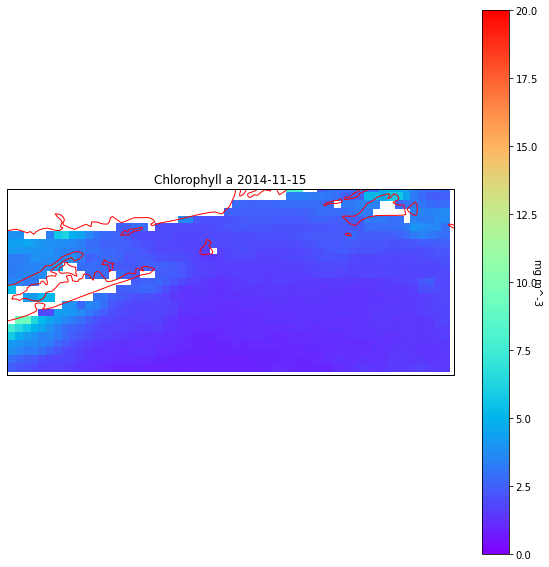

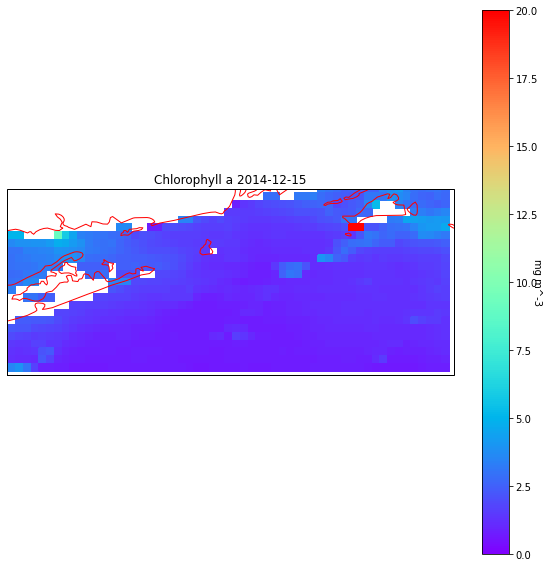

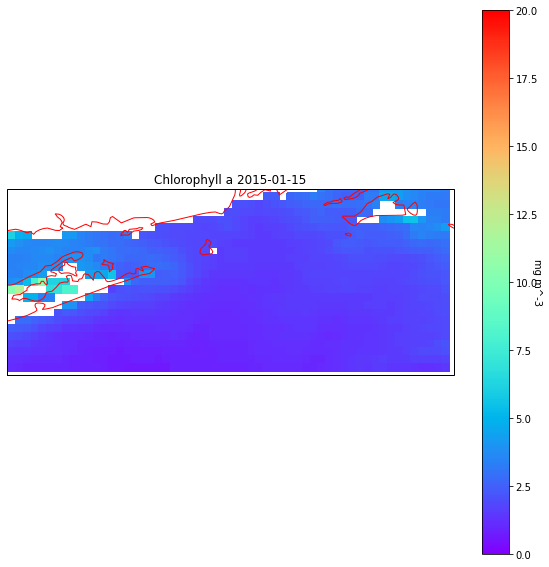

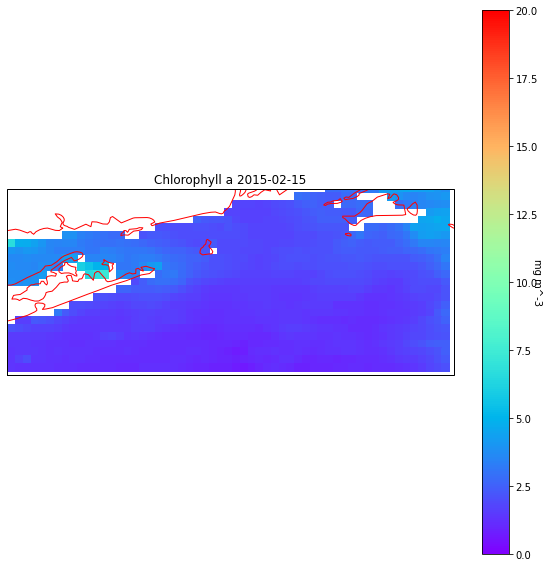

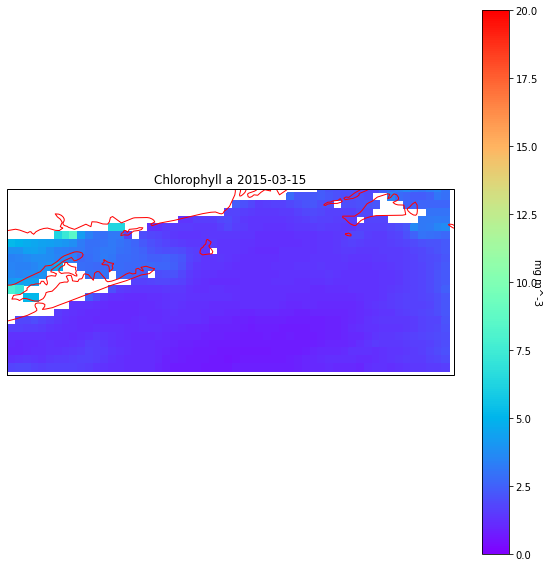

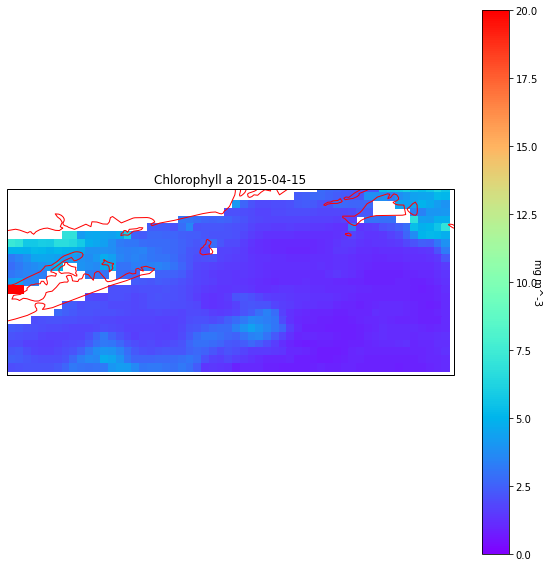

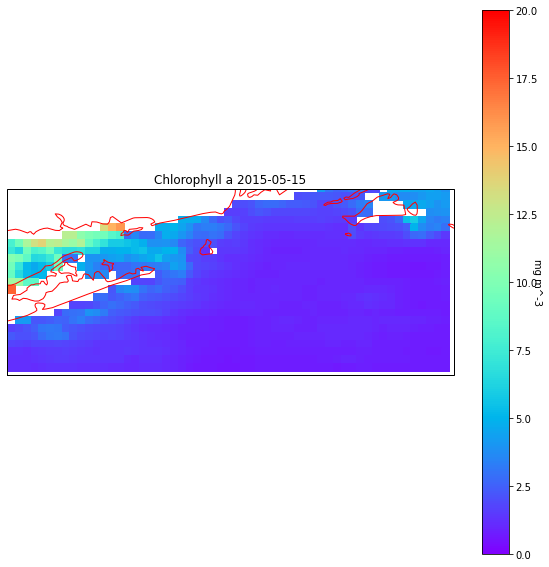

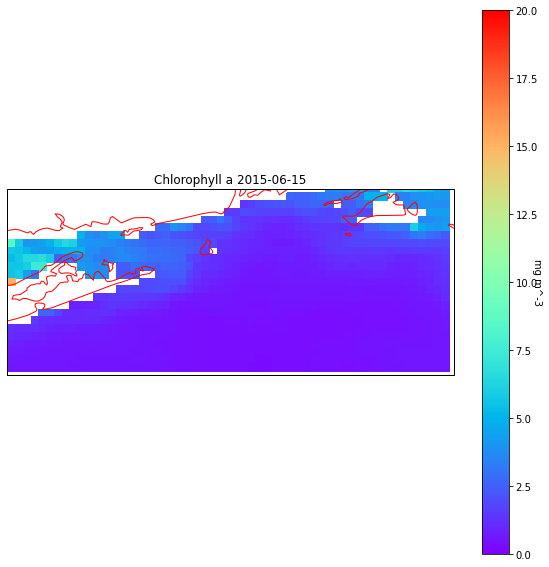

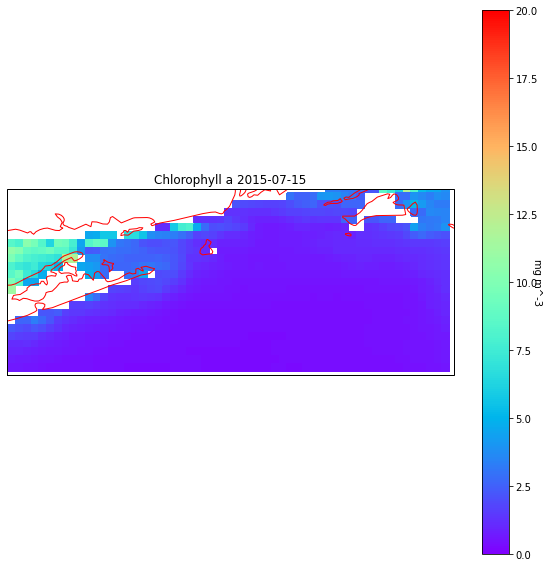

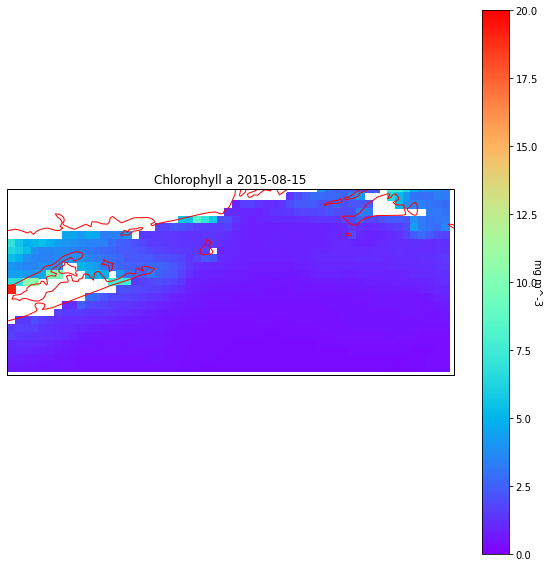

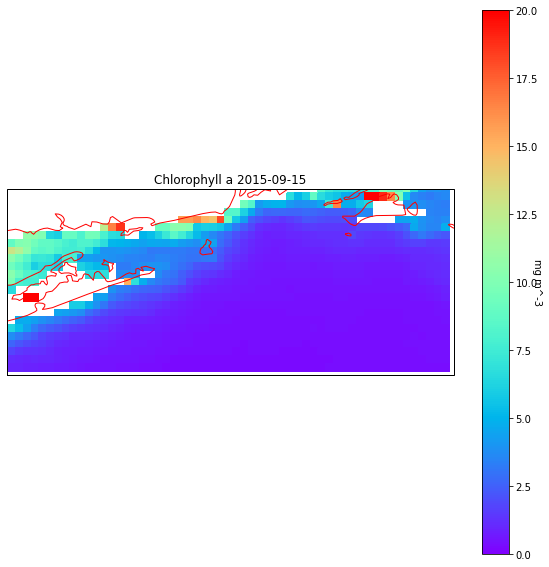

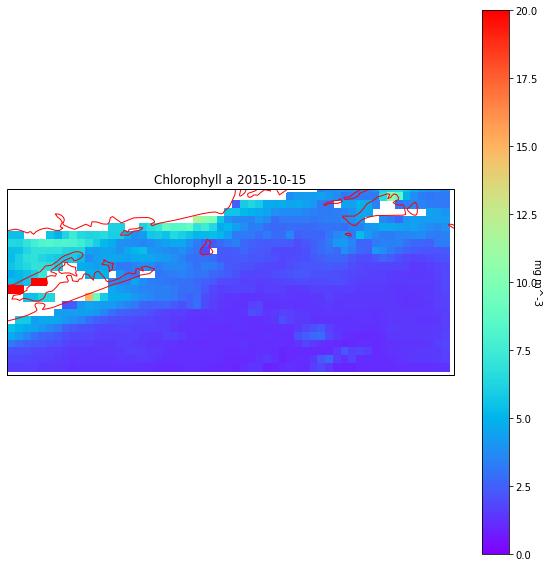

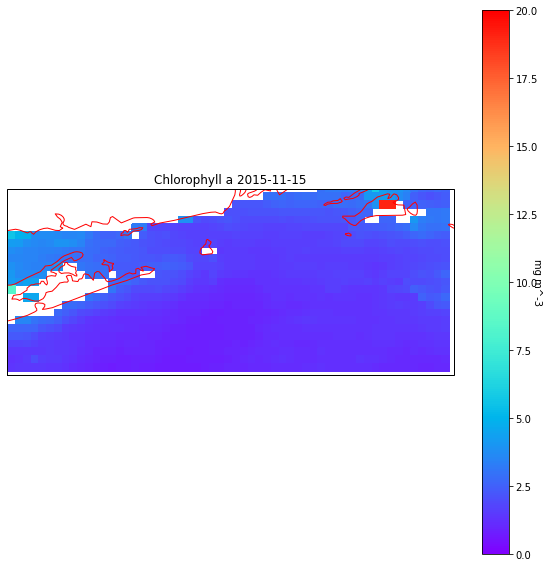

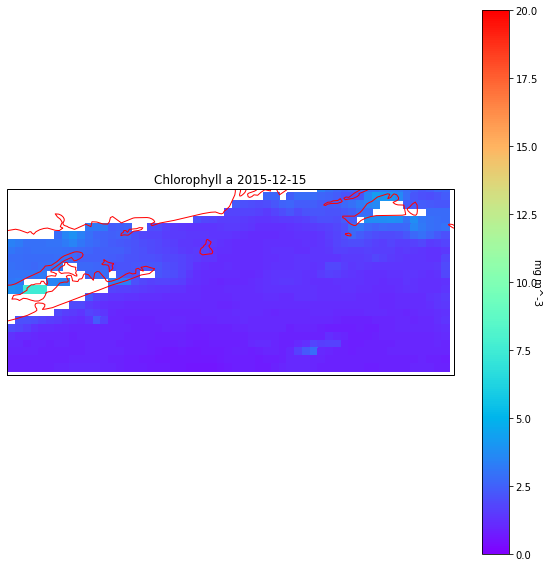

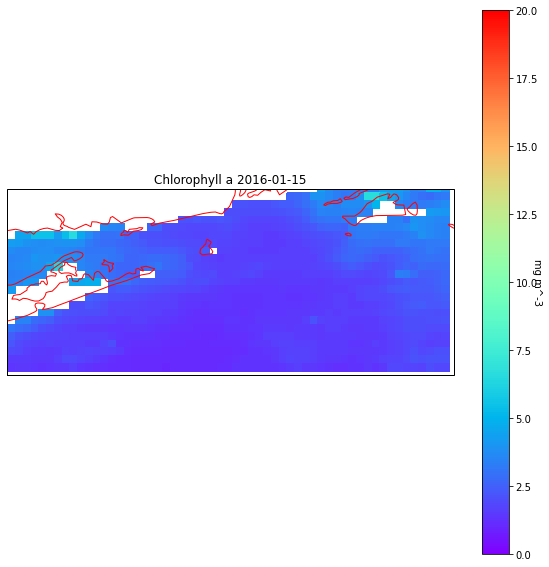

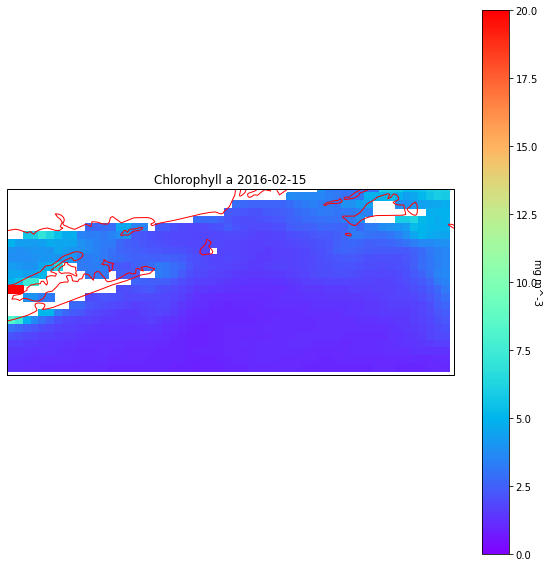

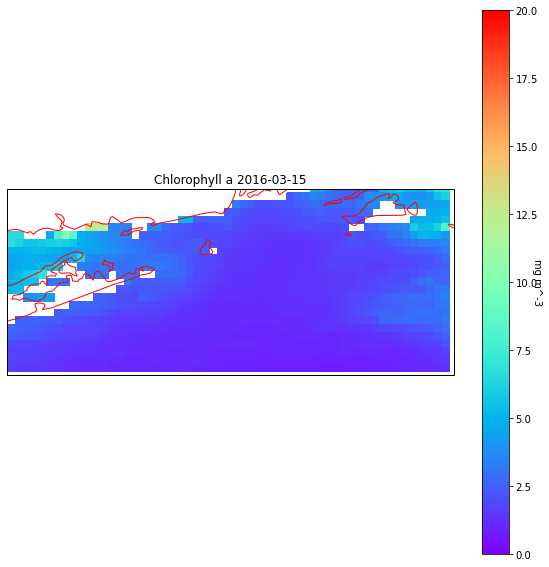

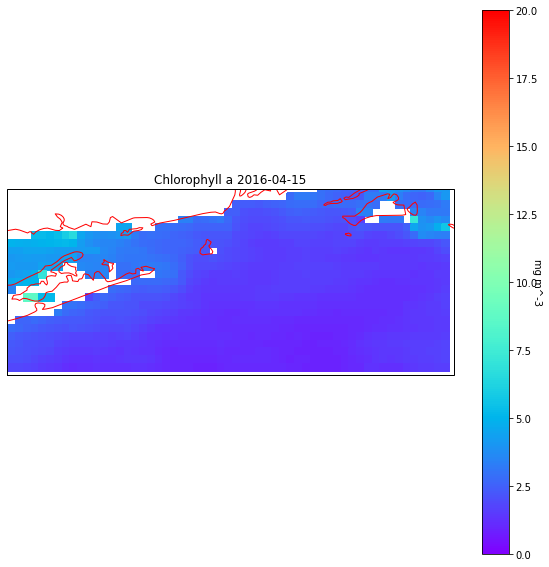

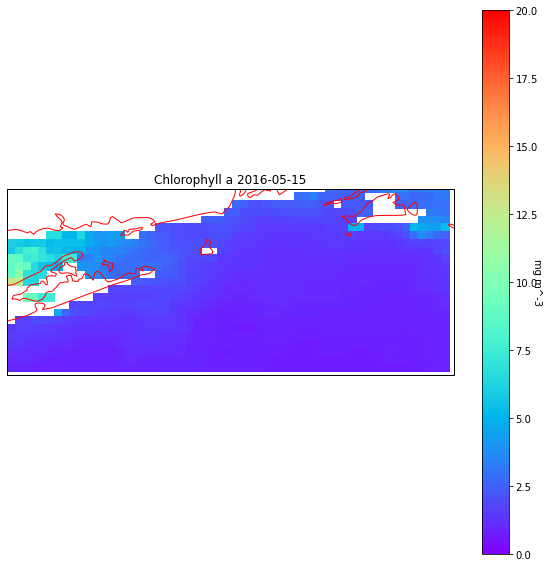

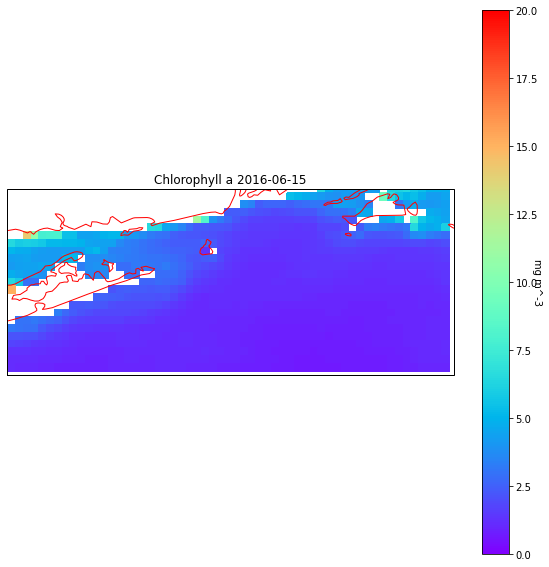

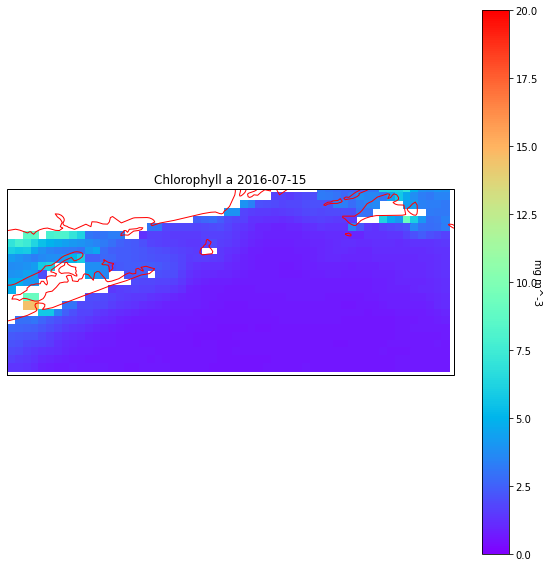

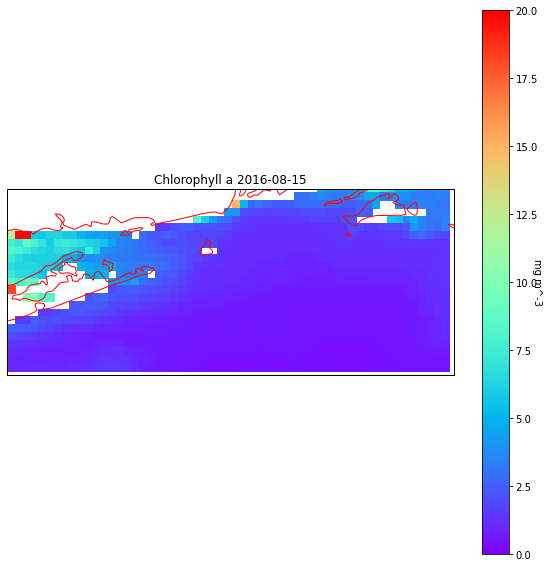

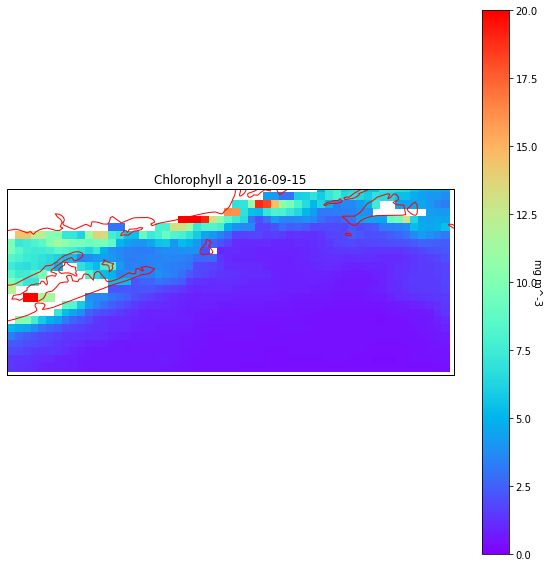

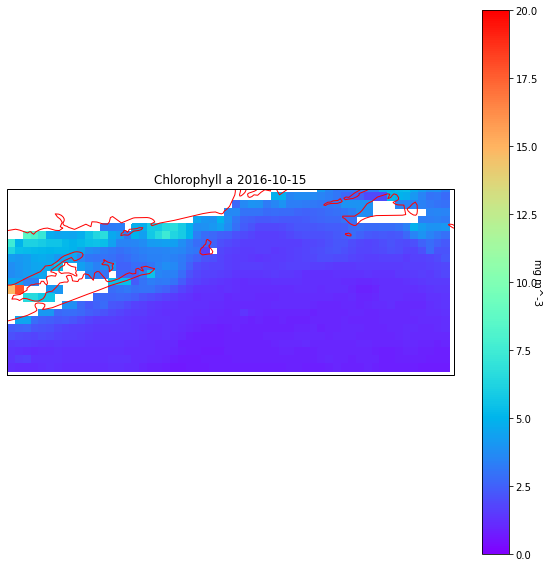

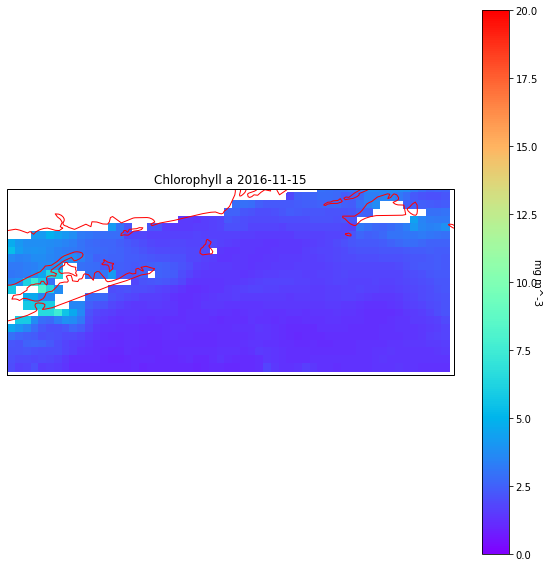

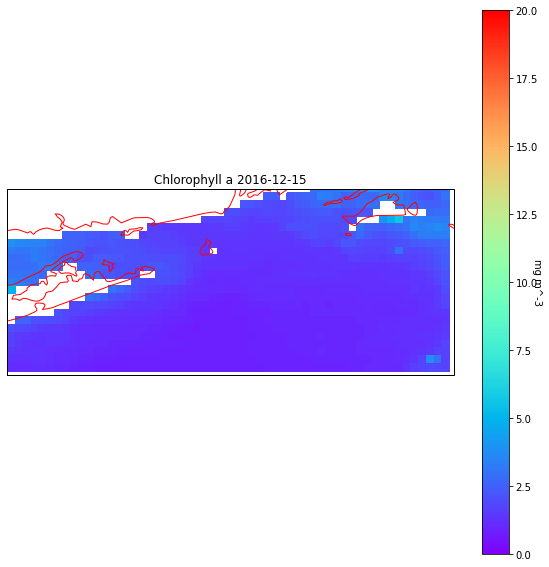

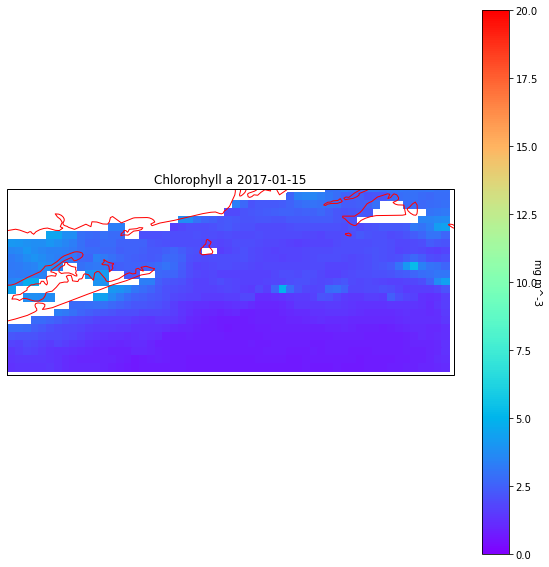

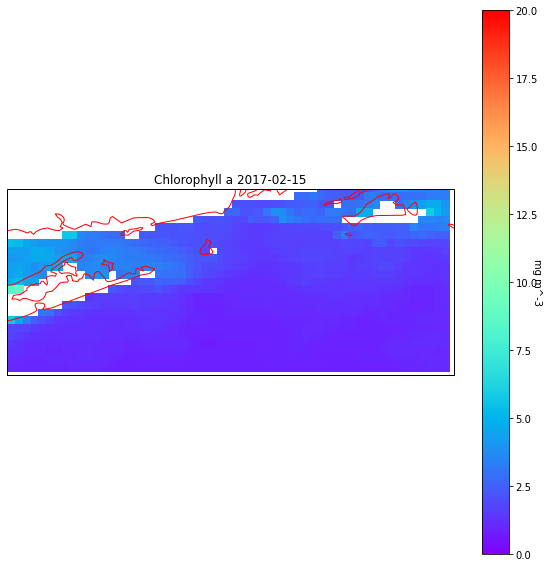

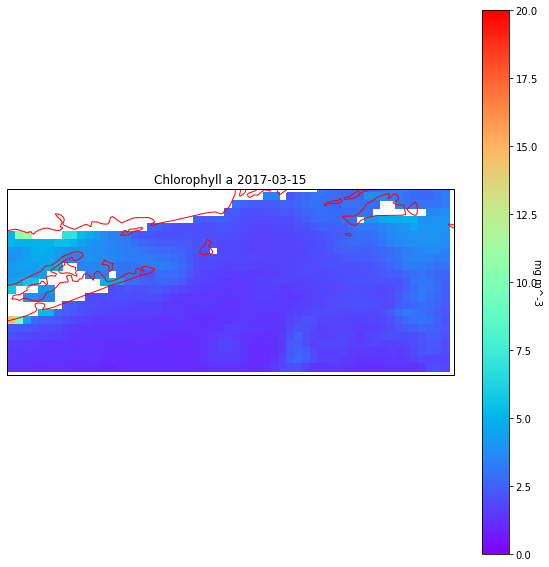

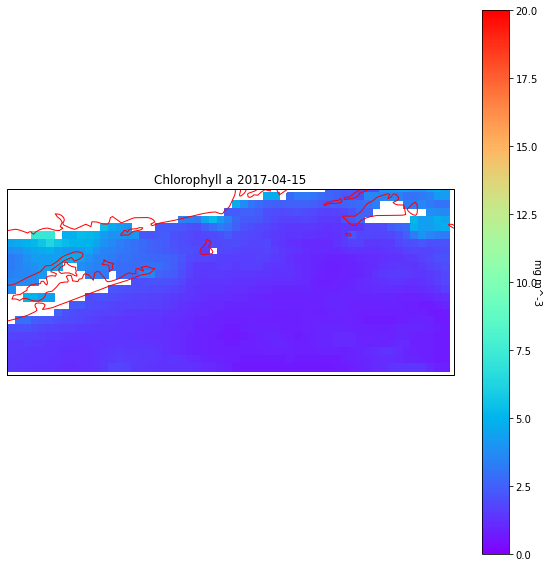

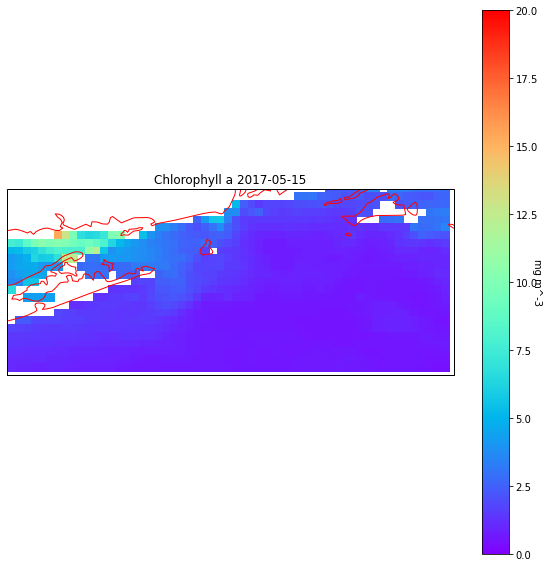

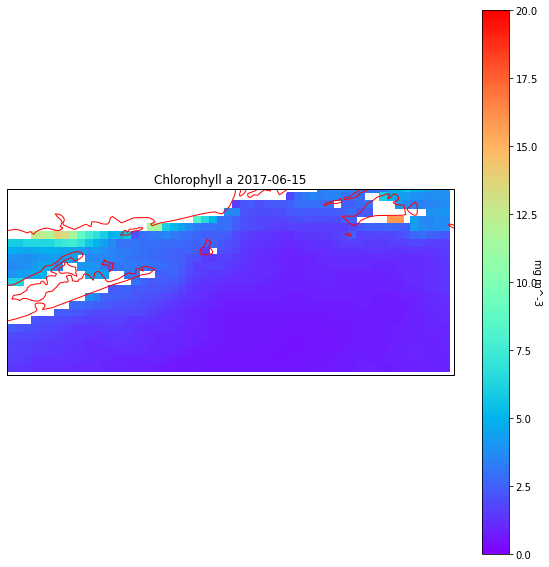

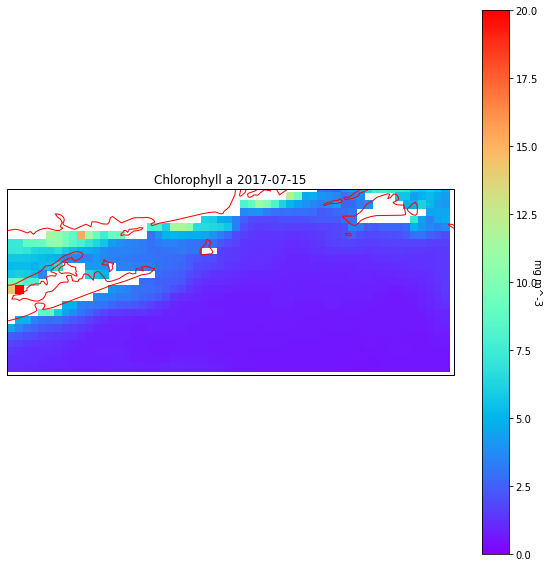

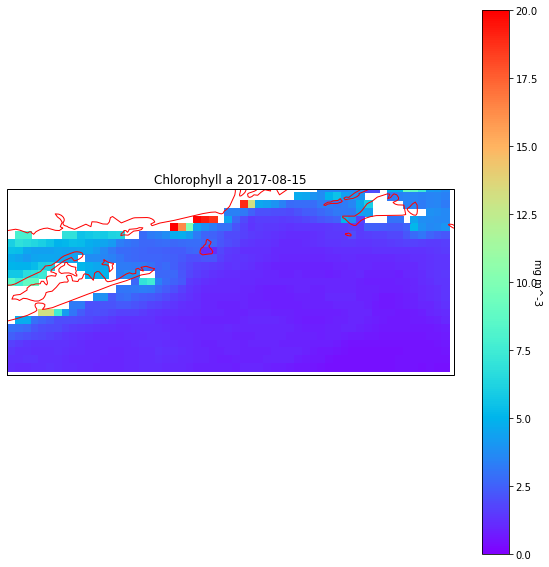

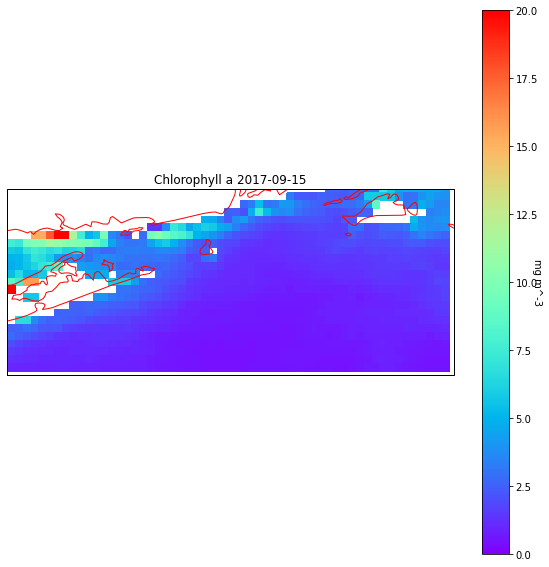

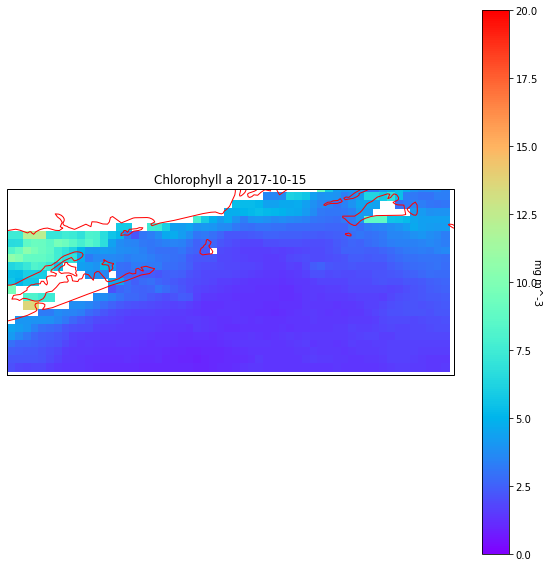

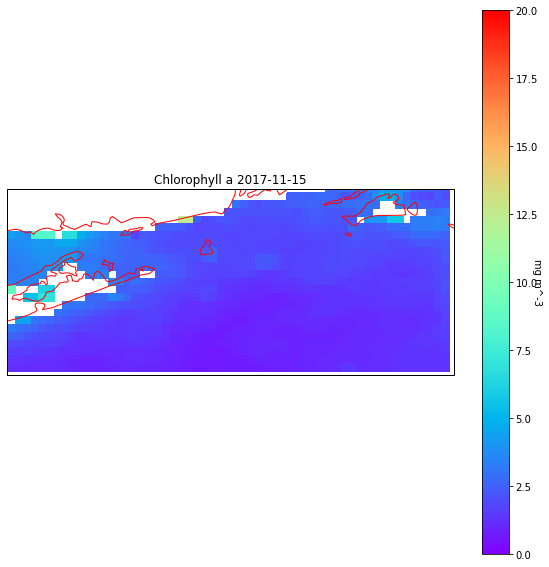

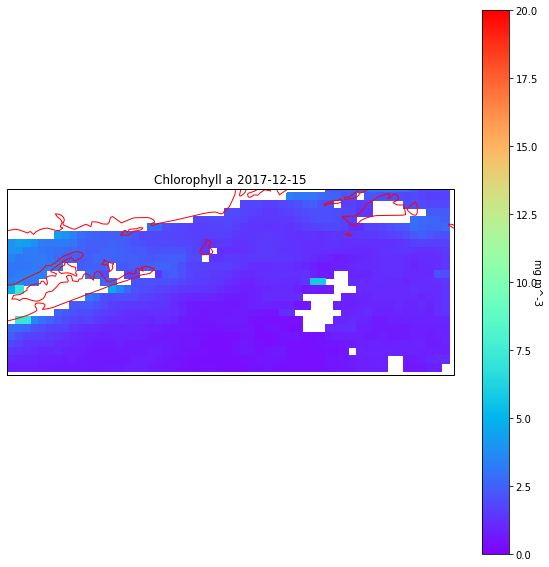

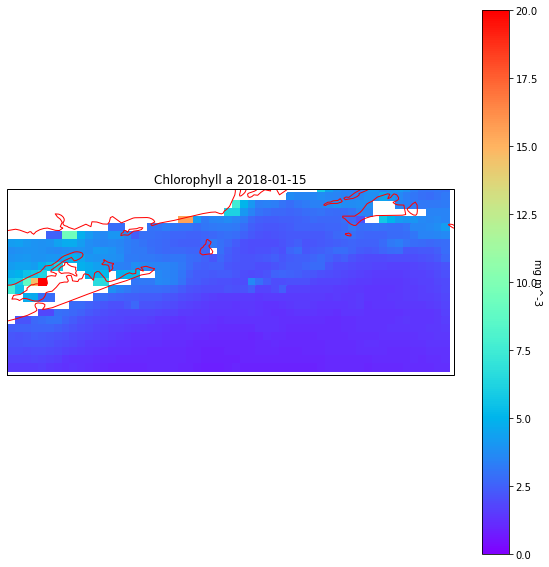

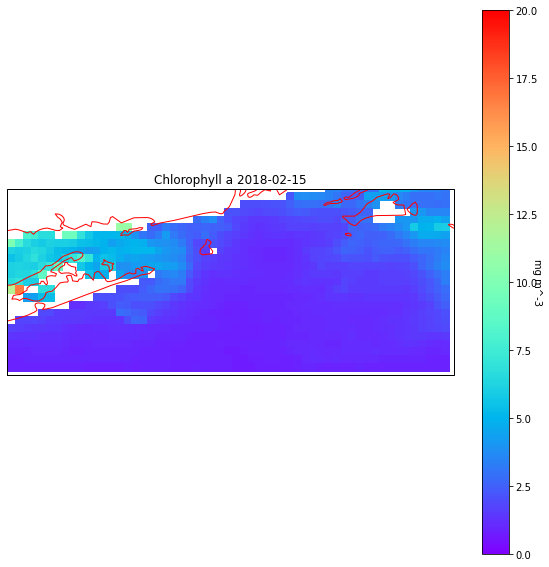

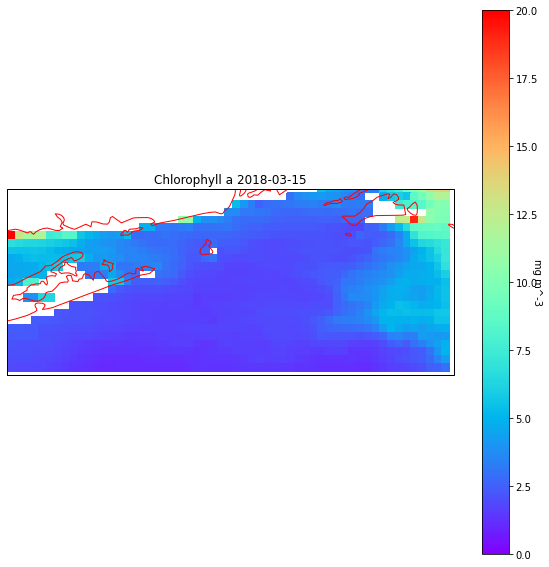

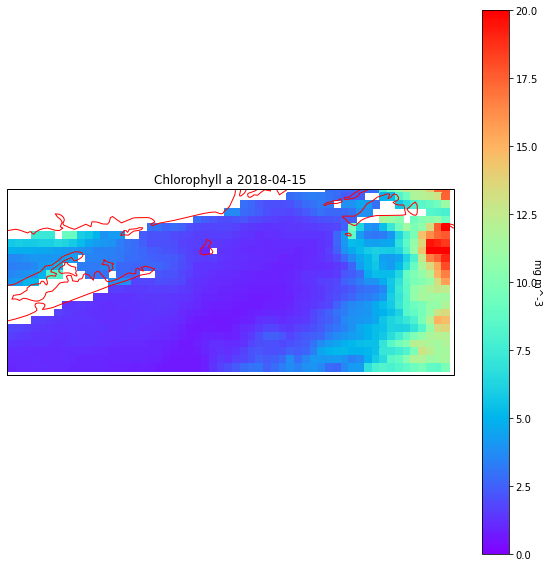

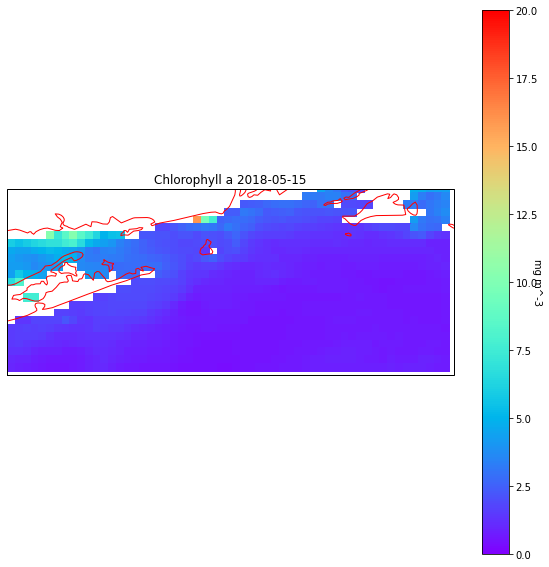

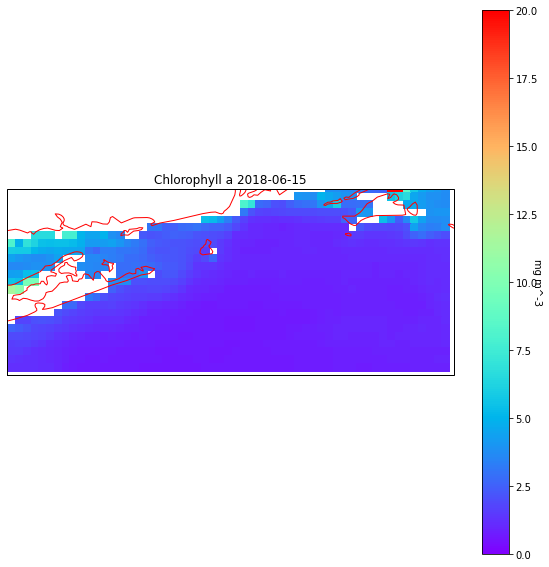

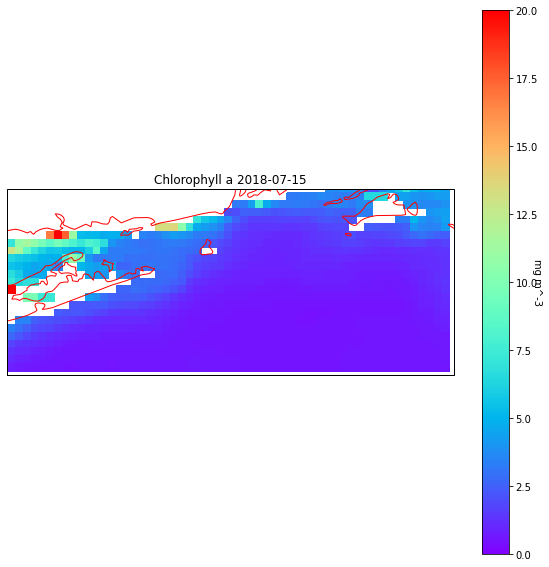

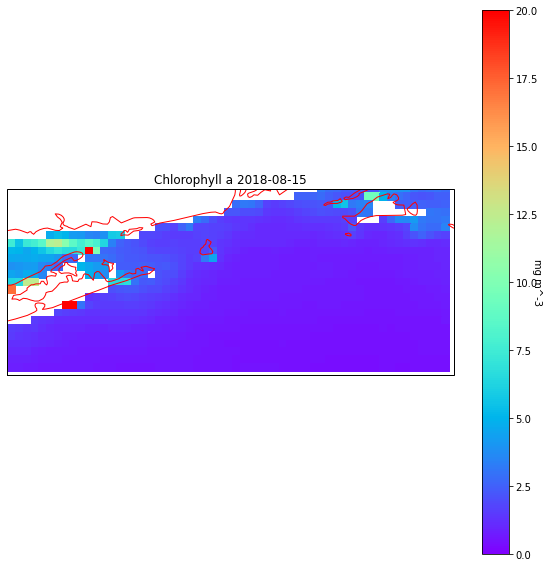

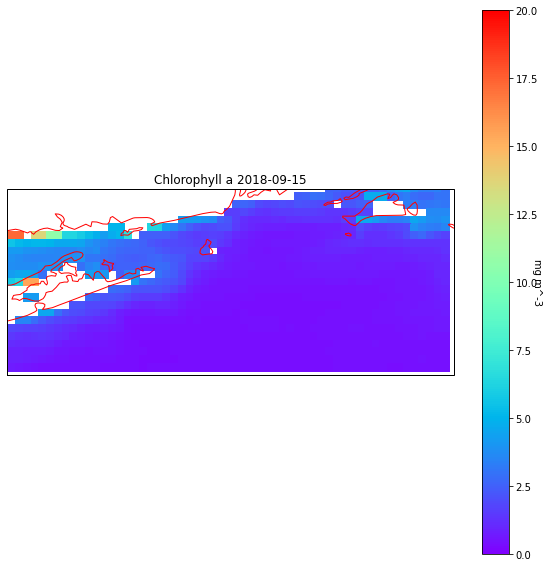

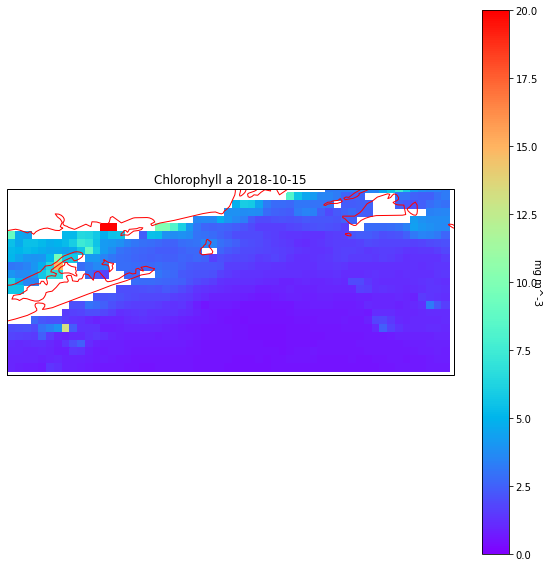

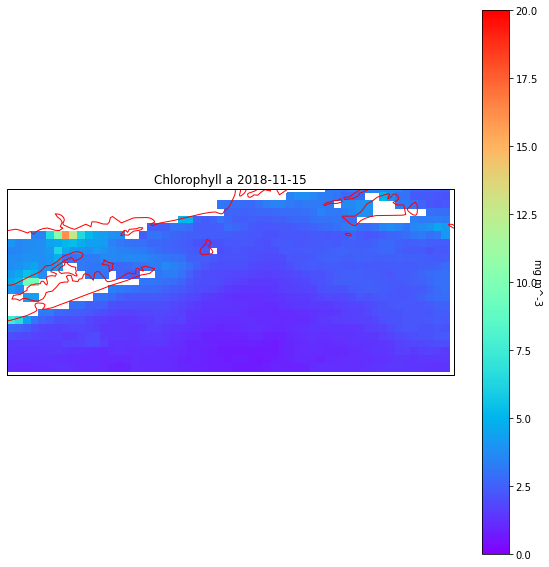

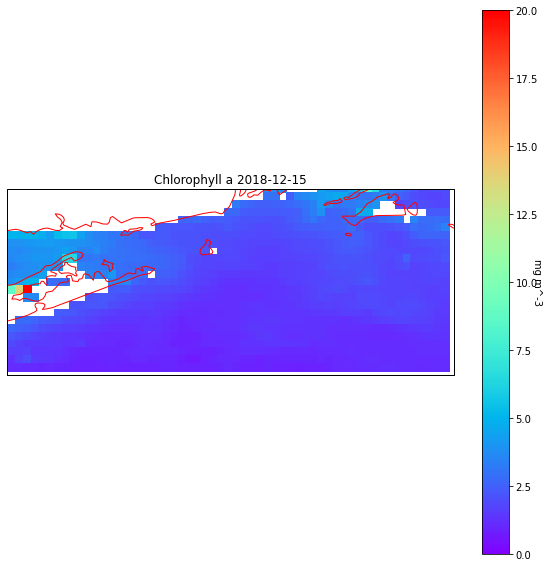

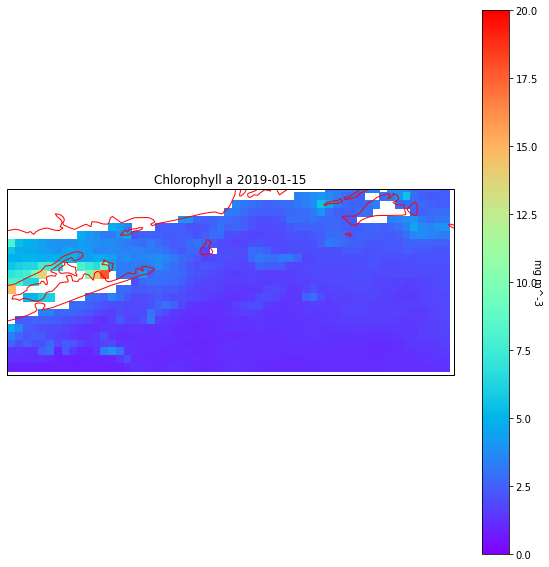

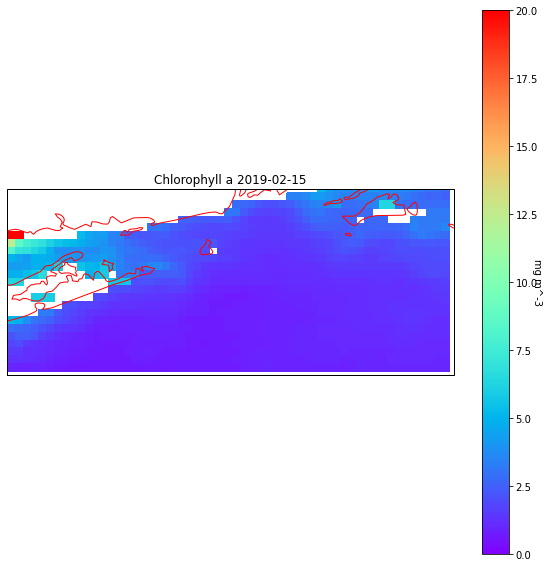

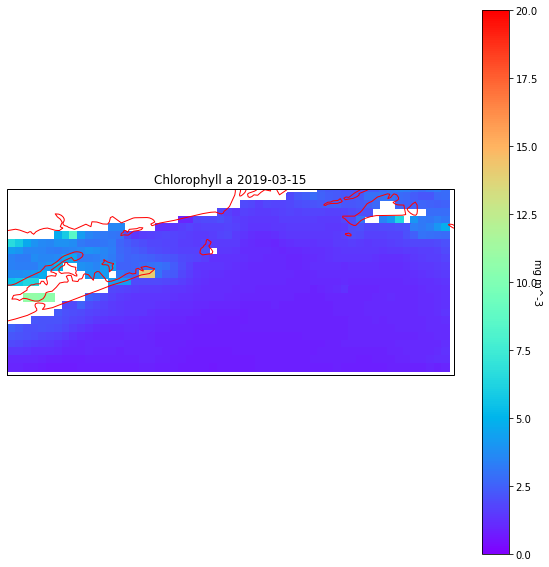

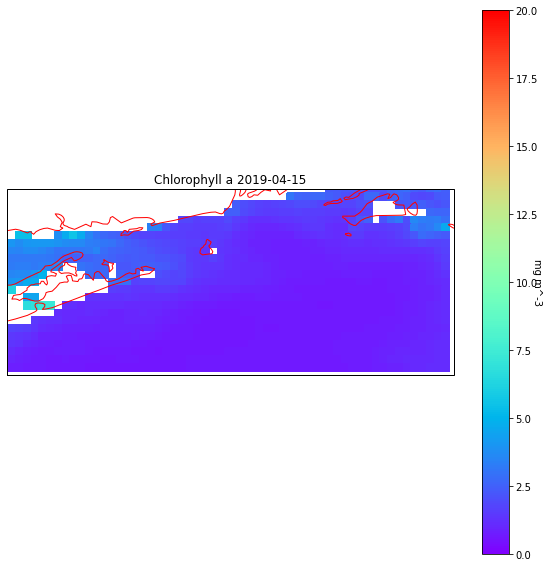

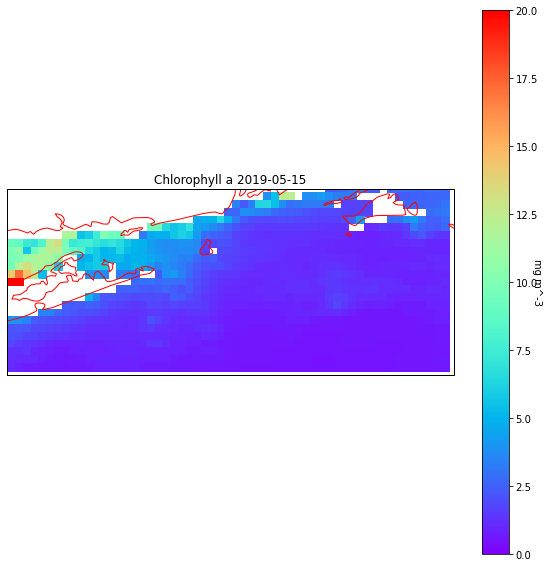

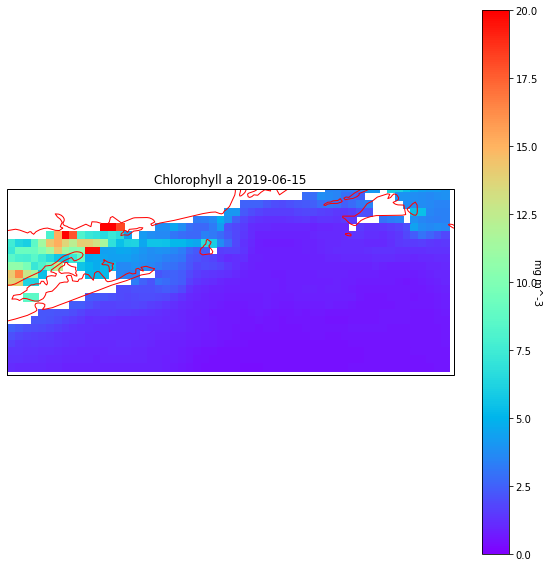

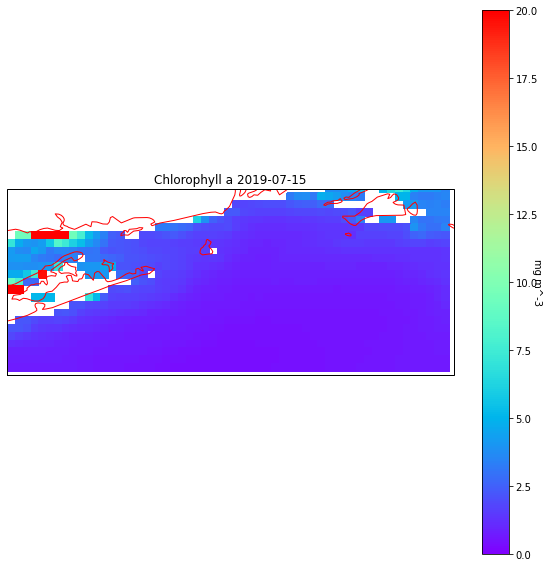

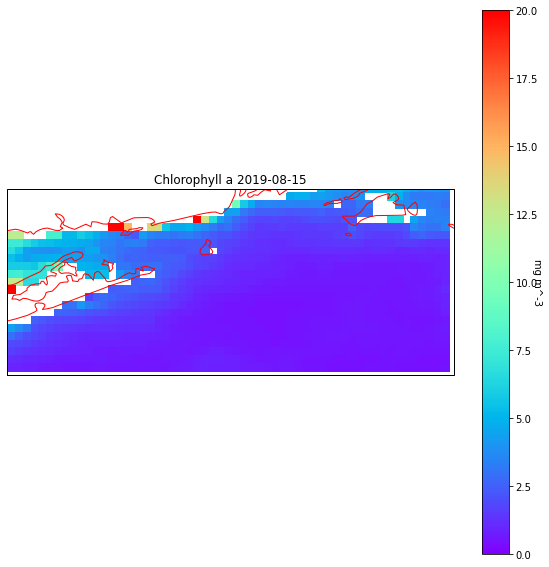

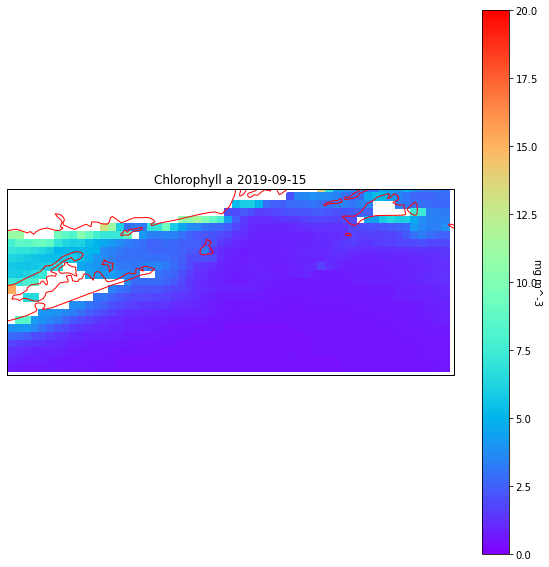

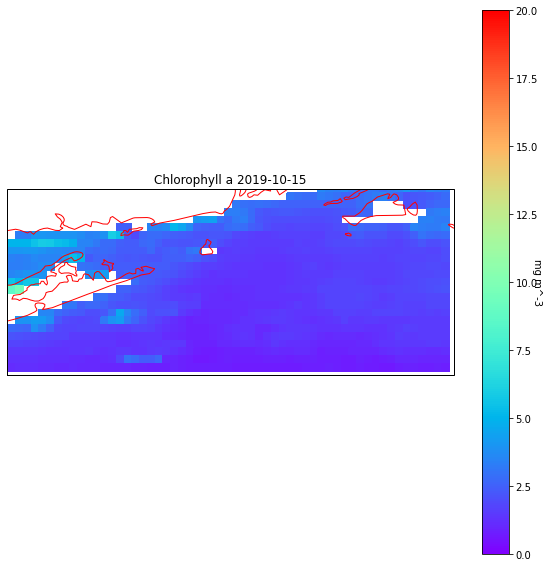

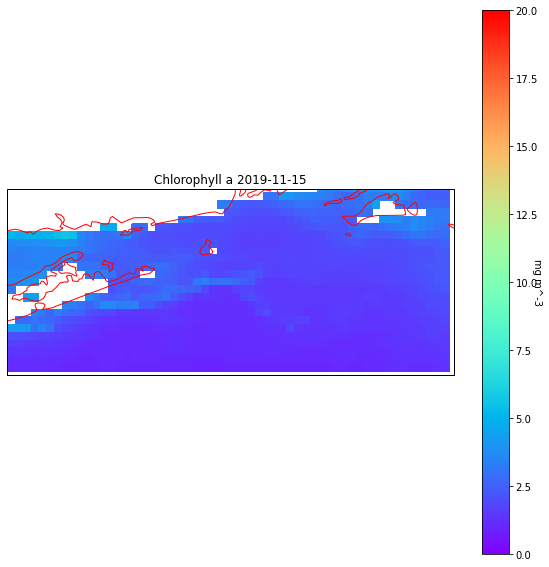

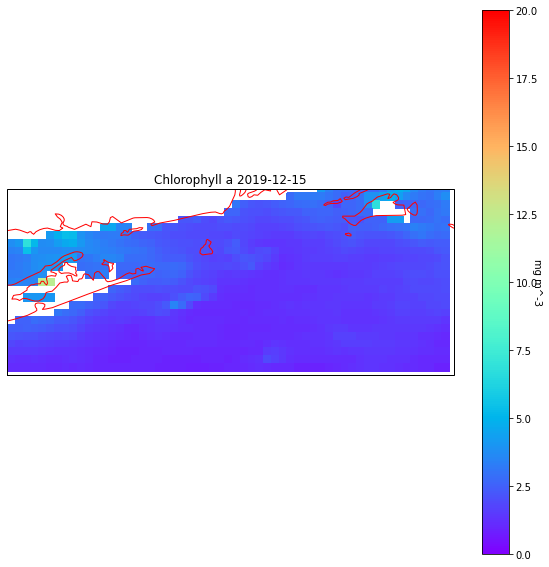

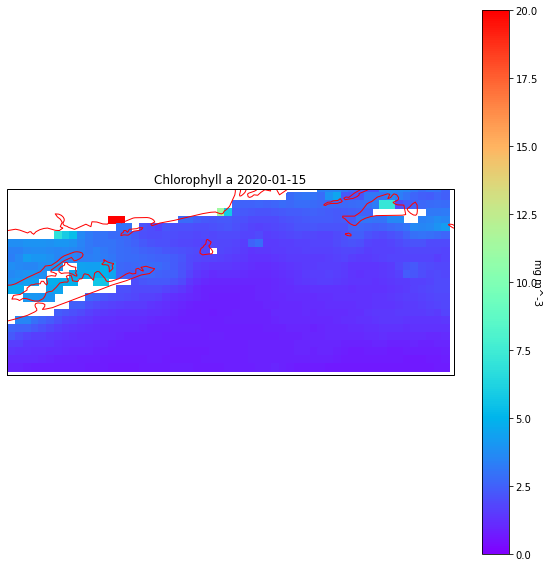

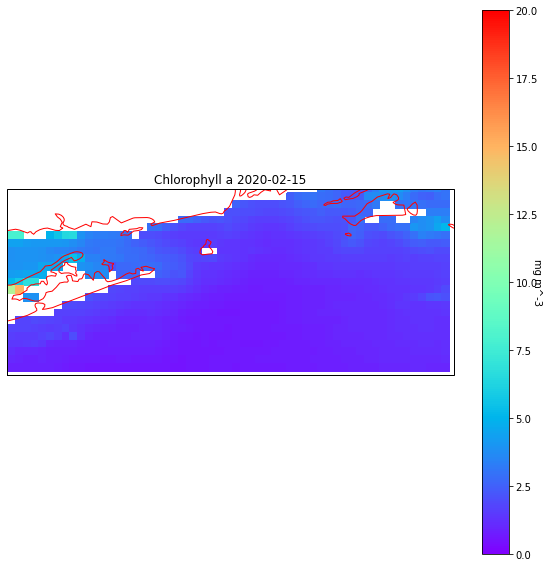

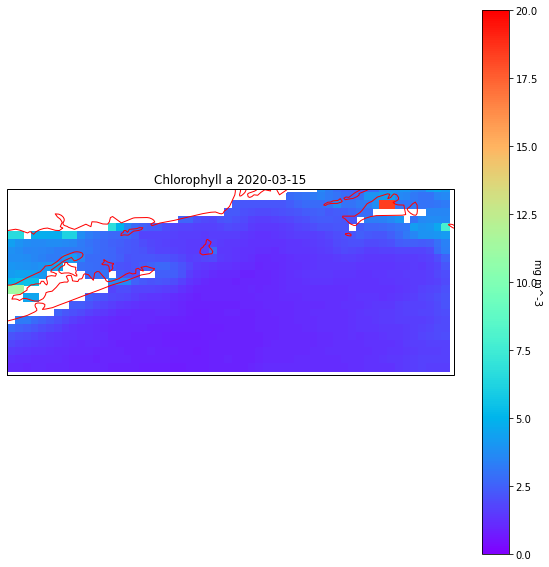

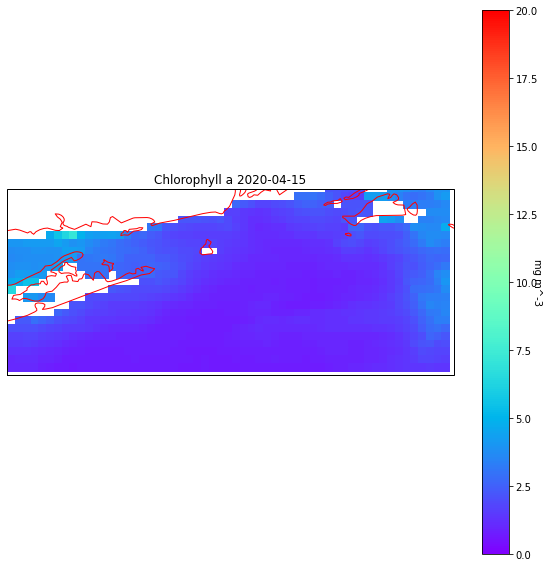

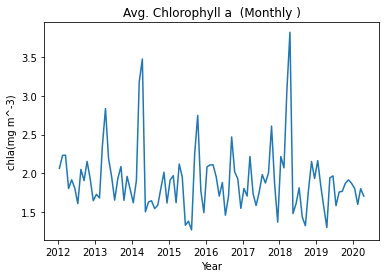

In [6]:
means = [] #this list will be added to as I loop through each time stamp
timearray = [] #I'll use this list for plotting
def make_url():
  for i in dates2:
    #In the following lines, I create a url, and make a netcdf4 Dataset within Colab using the data at that url.
    #Note that in the url, I am constraining the latitude & longitude in a specific way. They are constrained to match up with part of the region that has been modeled with the Ocean State Ocean Model.
    #This portion of the code is why it's so slow. Creating a new url for each time stamp and going to that link takes up a lot of time.
    #A faster version would take in all the times at once and use np.mean over particular axes to do the required averages. This is what I do in the notebook "MODIS & VIIRS Faster Comparisons"
    url = 'https://pricaimcit.services.brown.edu/erddap/griddap/'+dataset_id+'.nc?'+myvar+'[('+i+'T00:00:00Z):1:('+i+'T00:00:00Z)][(41.5):1:(40.5)][(-72.65):1:(-70.25)]'
    r = requests.get(url, allow_redirects=True)
    open('test.nc', 'wb').write(r.content)
    nc = NetCDFFile('test.nc')
    nc
    #Defining my variables:
    lat = nc.variables['latitude'][:]
    lon = nc.variables['longitude'][:]
    time = nc.variables['time'][:]
    mapvar = nc.variables[myvar][:]
    fig = plt.figure(i, figsize = (10, 10))
    #Using cartopy to put coastlines on the map:
    ax = plt.axes(projection = ccrs.PlateCarree())
    ax.coastlines(resolution='10m', color = 'red')
    ax.set_extent([287.35, 289.75, 40.5, 41.5])
    #making a pcolormesh of the data:
    myplot = plt.pcolormesh(lon, lat, mapvar[0,:,:], cmap = 'rainbow', vmin = 0, vmax = 20) #vmin and vmax determine the extent of the colorbar, making comparisons of the plots easier. You can delete the vmin and vmax to see the full extent of the data.
    means.append((np.mean(mapvar))) #taking the average over the region, putting it in the list
    timearray.append(dt.fromtimestamp(time)) #adding to the list of times
    plt.title(title+i)
    cbar = plt.colorbar()
    cbar.set_label(unit, rotation=270) 
    plt.show()
    #Saving the figure:
    #plt.savefig(f"{images_dir}/Photosynthetically Available Radiation (1 day Composite) "+i+".png")
  plt.plot(timearray, means) #plotting the averages over time
  plt.xlabel('Year')
  plt.ylabel(myvar+'('+unit+')')
  plt.title('Avg. '+title+' ('+tt+')')
  #plt.savefig(f"{images_dir}/"+tt+myvar+" VIIRS.png")
  plt.show()
make_url()

**Making a climatology from monthly composite**

Again, this is an extremely slow way to make the climatology. For a faster version, see "MODIS & VIIRS Faster Comparisons."

Also, this code will only make the monthly climatology, not the 8 Day or 1 Day climatology. I have not yet written code for higher-resolution climatologies.

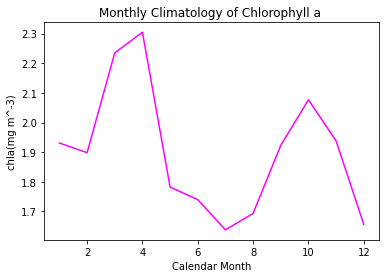

In [8]:
#images_dir = '/content/gdrive/Shared drives/BFK_BOG/SURF_UG/Benny/Images/Phytoplankton_averages/Monthly Climatologies'
#The following nested for loop makes a list (monthdates) of dates in each month, and puts that array within a list of lists (metadates) that should have 12 elements when completed.
metadates = []
metameans = []
months = []
for y in range(1,13):
  months.append(y)
for k in range(1, 13):
  monthdates = []
  for i in dates2:
    datee = dt.strptime(i, "%Y-%m-%d")
    if datee.month == k:
      monthdates.append(i)
  metadates.append(monthdates)
#Now I'll iterate through all the dates of each month. Each element of metadates is a list of dates for that month, so I have a nested for loop.
#For each date, I create a url, calculate a mean over the region, and put that mean in a list of means for that particular month (the list called means). Then I append means to metameans, which, like metadates, will have an element for each of 12 months.
for j in metadates:
  means = []
  for x in metadates[metadates.index(j)]:
    url = 'https://pricaimcit.services.brown.edu/erddap/griddap/'+dataset_id+'.nc?'+myvar+'[('+x+'T00:00:00Z):1:('+x+'T00:00:00Z)][(41.5):1:(40.5)][(-72.65):1:(-70.25)]'
    r = requests.get(url, allow_redirects=True)
    open('test.nc', 'wb').write(r.content)
    nc = NetCDFFile('test.nc')
    nc
    mapvar = nc.variables[myvar][:]
    means.append(np.nanmean(mapvar))
  metameans.append(means)
finalmeans = []
#lastly, I take the average of each list within metameans and put that average in finalmeans
#finalmeans is a list of 12 numbers that can be graphed against month
for z in metameans:
  finalmeans.append(np.nanmean(metameans[metameans.index(z)]))
plt.plot(months, finalmeans, color = 'magenta')
plt.title('Monthly Climatology of '+title)
plt.xlabel('Calendar Month')
plt.ylabel(myvar+'('+unit+')')
#plt.savefig(f"{images_dir}/"+tt+"Climatology"+myvar+" VIIRS.png")
plt.show()

**Graphing the anomaly**

This code takes the seasonal pattern found in the previous cell and subtracts it from the entire dataset to get the anomalies.

Again, this is slow. See "MODIS & VIIRS Faster Comparisons."

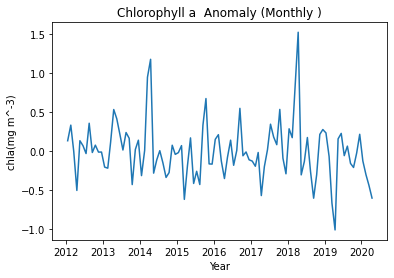

In [9]:
anomalies = [] #I'll make the anomalies list by subtracting the mean at each time stamp from the climatological norm as calculated in the previous cell
means = []
timearray = []
#images_dir = '/content/gdrive/Shared drives/BFK_BOG/SURF_UG/Benny/Images/Phytoplankton_averages/Anomalies/VIIRS Anomalies'
def anomaly():
  for i in dates2:
    url = 'https://pricaimcit.services.brown.edu/erddap/griddap/'+dataset_id+'.nc?'+myvar+'[('+i+'T00:00:00Z):1:('+i+'T00:00:00Z)][(41.5):1:(40.5)][(-72.65):1:(-70.25)]'
    r = requests.get(url, allow_redirects=True)
    open('test.nc', 'wb').write(r.content)
    nc = NetCDFFile('test.nc')
    nc
    lat = nc.variables['latitude'][:]
    lon = nc.variables['longitude'][:]
    time = nc.variables['time'][:]
    mapvar = nc.variables[myvar][:]
    index = datetime.datetime.strptime(i, '%Y-%m-%d').month
    #get the anomaly at this time by suptracting the mean at this month
    addition = np.nanmean(mapvar) - finalmeans[index-1]
    anomalies.append(addition)
    timearray.append(dt.fromtimestamp(time))
    #plt.savefig(f"{images_dir}/Photosynthetically Available Radiation (1 day Composite) "+i+".png")
  plt.plot(timearray, anomalies)
  plt.xlabel('Year')
  plt.ylabel(myvar+'('+unit+')')
  plt.title(title+' Anomaly ('+tt+')')
  #plt.savefig(f"{images_dir}/"+tt+myvar+" Anomaly VIIRS.png")
  plt.show()
anomaly()